# **Signa_Lab ITESO: Depuración, análisis exploratorio de preguntas recibidas y elaboración de muestra estratificada**

## **Proyecto:** *Selección de Preguntas de Redes Sociales para 1er Debate Presidencial INE 2024 (Formato A)*

Cuaderno de código diseñado para procesar, explorar, depurar y elaborar una muestra estratificada de preguntas contenidas en los registros entregados por el INE a Signa_Lab ITESO, a partir de las de entradas recibidas al formulario digital dispuesto para la recepción de preguntas ciudadanas para el 1er Debate Presidencial. 

## 1. Importar librerías y archivos de datos a depurar

**Instalar librerías necesarias**

In [ ]:
!pip install pandas
!pip install nltk
!pip install difflib 
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install numpy
!pip install plotly
!pip install time
!pip install tqdm

**Importar librerías** necesarias:

In [2]:
import pandas as pd
import nltk
import re
import sys
import re
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import gaussian_kde
import numpy as np
import plotly.express as px
import time
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import math

**Importar archivos de datos** con registros recibidos y diccionario para depuración por descarte:

In [3]:
# Ruta local de archivos a importar:
ruta1 = "./data/Corte1-Formulario-1erDebatePresidencial2024-03-22-00-03-15.xlsx"
ruta2 = "./data/Corte2-Formulario-1erDebatePresidencial2024-03-22-00-04-59.xlsx"


# Leer archivos de Excel con registros recibidos en formulario del INE
df1 = pd.read_excel(ruta1)
df2 = pd.read_excel(ruta2)

nombreArchivo = 'PreguntasDebateINE'

In [4]:
# Cargar diccionario con términos de descarte para depuración (de acuerdo a criterios definidos por el INE)
ruta = './data/debateINE_diccionarios_depuracion_25mar_1406hrs.csv'
dfDescarte = pd.read_csv(ruta)

Revisar **número de registros recibidos (entradas a formulario del INE)**

In [5]:
# Revisar el número de filas y columnas en archivo de datos original (archivo Corte 1)
df1.shape

(6496, 22)

In [6]:
# Revisar el número de filas y columnas en archivo de datos original (archivo Corte 2)
df2.shape

(6988, 22)

In [7]:
# Concatenar en una tabla ambos archivos importados y revisar el número de filas y columnas totales
df = pd.concat([df1, df2],axis=0,ignore_index=True)
df.shape

(13484, 22)

In [8]:
# Crear copia de trabajo de la tabla concatenada de registros recibidos
dfTest = df.copy()

Agregar columna de **"región" correspondiente a la entidad** indicada en cada registro del formulario, a partir de la delimitación de regiones definida en el documento de metodología, Anexo I (INE, 2024):

In [9]:
# Definir función para asignar región correspondiente a la entidad indicada en registro
def addRegionColumn(df, columnaEntidad):
  regiones = {
    'norte': ['Baja California', 'Baja California Sur', 'Sonora', 'Chihuahua', 'Coahuila', 'Nuevo León', 'Tamaulipas', 'Sinaloa', 'Durango', 'Zacatecas', 'Nayarit'],
    'centro': ['Jalisco', 'Aguascalientes', 'San Luis Potosí', 'Querétaro', 'Ciudad de México', 'México', 'Michoacán', 'Colima', 'Tlaxcala', 'Morelos', 'Hidalgo', 'Guanajuato'],
    'sur': ['Veracruz', 'Tabasco', 'Campeche', 'Yucatán', 'Quintana Roo', 'Chiapas', 'Guerrero', 'Oaxaca', 'Puebla']
  }

  # Definir función para asignar región por entidad
  def get_region(state):
      for region, states in regiones.items():
          if state in states:
              return region
      return None


  df["region"] = ""
  for i, row in df.iterrows():
      df.loc[i, "region"] = get_region(row[columnaEntidad])

  return df

In [10]:
# Ejecutar función para agregar valores correspondientes en nueva columna de región por cada registro
dfTest = addRegionColumn(df,'¿Cuál es tu entidad de origen?' )

In [11]:
# Se transforman los valores de la columna "Edad" para poder manejar números enteros (Int)
dfTest['Edad:'] = dfTest['Edad:'].str.replace(r'(\d+)\s*años?', r'\1', regex=True)
dfTest['Edad:'] = dfTest['Edad:'].astype(int)

In [ ]:
# Previsualizar tabla que concatena los 13,484 registros con región indicada
dfTest

In [13]:
# Exportar archivo CSV con tabla concatenada de 13,484 registros con región indicada
dfTest.to_csv(f"{nombreArchivo.split('.')[0]}_RegistrosConcatenados_Regiones.csv")

---

## 2. Análisis Exploratorio de Registros Recibidos (Entradas a Formulario del INE)

### Registros por Entidad y Región:

In [14]:
# Enlistar registros recibidos por región
df['region'].value_counts()

region
centro    8329
sur       2867
norte     2288
Name: count, dtype: int64

Registros recibidos **por región:**

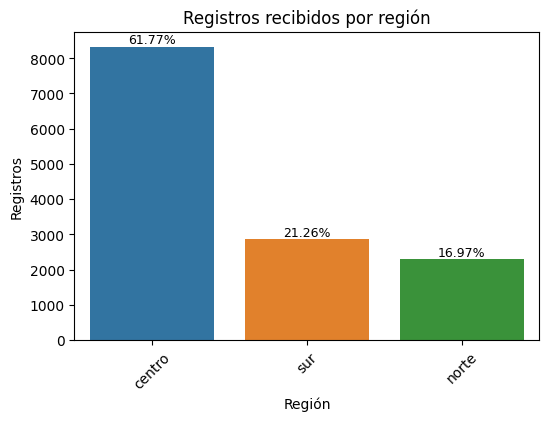

In [15]:
# Crear gráfica de registros por región
total_entries = len(dfTest)
counts = dfTest['region'].value_counts()
percentage = counts / total_entries * 100

column = 'region'
figsize = (6, 4)  # Ajusta el tamaño de la figura según tus preferencias
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(x=counts.index, y=counts.values, order=counts.index, hue=counts.index, ax=ax)
plt.title(f'Registros recibidos por región')
plt.ylabel('Registros')
plt.xlabel('Región')
plt.xticks(rotation=45)
plt.grid(False)

# Añadir los valores de porcentaje en las barras
for index, value in enumerate(counts.values):
    ax.annotate(f'{percentage.iloc[index]:.2f}%', xy=(index, value), ha='center', va='bottom', fontsize=9)

plt.show()

Registros recibidos **por entidad:**

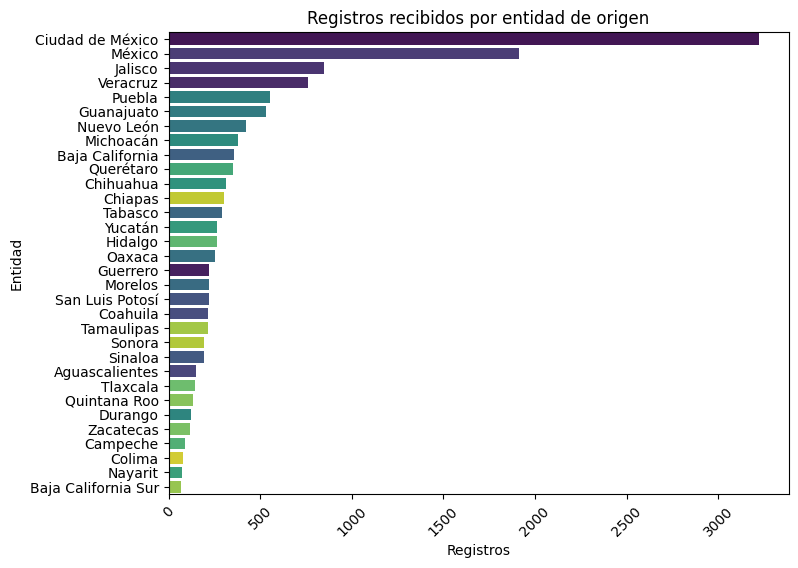

In [16]:
# Crear gráfica de registros por entidad

column = '¿Cuál es tu entidad de origen?'
figsize = (8,6)
orden = dfTest[column].value_counts().index
plt.figure(figsize=figsize)
sns.countplot(data=dfTest, y=column, hue=column, palette='viridis', order=orden, legend=False)
plt.title(f'Registros recibidos por entidad de origen')
plt.xlabel('Registros')
plt.ylabel('Entidad')
plt.xticks(rotation=45)
plt.show()

Tabla cruzada de **cantidades y porcentajes de registros recibidos por entidad:**

In [17]:
# Definir función para imprimir tabla cruzada:
def tabla(df, column):
    conteo_tema = df[column].value_counts().sort_index()
    total = conteo_tema.sum()
    porcentajes = [(index, count, count/total * 100) for index, count in conteo_tema.items()]
    data = [[index, count, f"{percentage:.2f}%" ] for index, count, percentage in porcentajes]

    df_test = pd.DataFrame(data, columns=[column, 'Cantidad', 'Porcentaje'])

    return df_test

In [18]:
tabla(dfTest,'¿Cuál es tu entidad de origen?').sort_values(by=['Cantidad'],ascending=False).T

,6,16,13,29,20,10,18,14,1,21,...,24,0,28,22,9,31,3,8,17,2
¿Cuál es tu entidad de origen?,Ciudad de México,México,Jalisco,Veracruz,Puebla,Guanajuato,Nuevo León,Michoacán,Baja California,Querétaro,...,Sinaloa,Aguascalientes,Tlaxcala,Quintana Roo,Durango,Zacatecas,Campeche,Colima,Nayarit,Baja California Sur
Cantidad,3223,1911,850,761,553,533,423,379,355,354,...,193,151,144,131,121,115,91,77,74,70
Porcentaje,23.90%,14.17%,6.30%,5.64%,4.10%,3.95%,3.14%,2.81%,2.63%,2.63%,...,1.43%,1.12%,1.07%,0.97%,0.90%,0.85%,0.67%,0.57%,0.55%,0.52%


### Registros por Edad:

Distribución de registros **por edad:**

In [19]:
# Enlistar medidas para describir la distribución por edad
dfTest.describe()

,Edad:
count,13484.000000
mean,38.293311
std,17.870468
min,13.000000
25%,22.000000
50%,35.000000
75%,54.000000
max,99.000000


In [20]:
# Enlistar valores de edad recibidos de mayor a menor frecuencia
dfTest['Edad:'].value_counts()

Edad:
18    571
20    463
19    381
17    379
21    362
     ... 
88      2
99      1
86      1
89      1
92      1
Name: count, Length: 78, dtype: int64

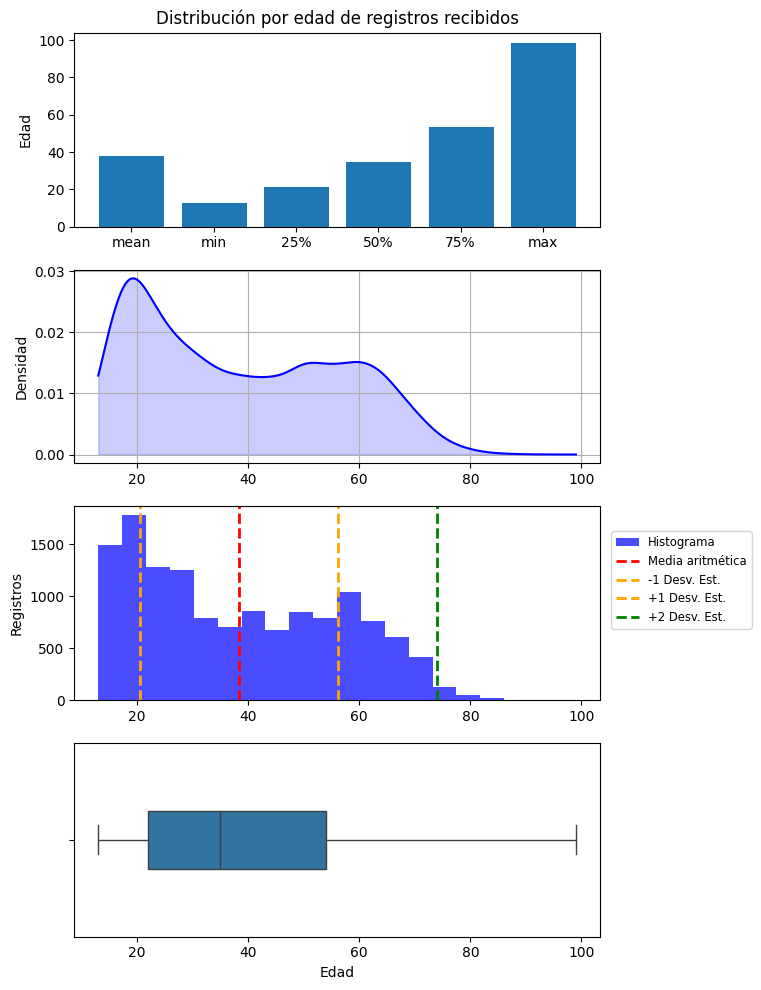

In [21]:
# Crear gráficas para visualizar registros por edad
column = 'Edad:'
x = dfTest[column].describe()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8,10))

# Medidas de tendencia central
x_labels = ['mean', 'min', '25%', '50%', '75%', 'max']
x_values = [x[label] for label in x_labels]
y = np.arange(len(x_labels))

axes[0].bar(y, x_values, width=0.8, edgecolor="white", linewidth=0.7)
axes[0].set_xticks(y)
axes[0].set_xticklabels(x_labels)
axes[0].set_title(f'Distribución por edad de registros recibidos')
axes[0].set_ylabel('Edad')

# Estimación de la densidad de probabilidad
edad = dfTest['Edad:']
kde = gaussian_kde(edad)

# Valores para evaluar la función de densidad
x = np.linspace(min(edad), max(edad), 1000)

# Función de densidad de probabilidad (PDF)
pdf = kde.evaluate(x)

# Visualización de la función de densidad de probabilidad
axes[1].plot(x, pdf, color='blue', label='PDF')
axes[1].fill_between(x, pdf, color='blue', alpha=.2)

axes[1].set_ylabel('Densidad')
axes[1].grid(True)

# Gráfica de barras con distribución por edad
n, bins, patches = axes[2].hist(dfTest[column], bins=20, density=False, alpha=0.7, color='blue', label='Histograma')
axes[2].axvline(x_values[0], color='red', linestyle='dashed', linewidth=2, label='Media aritmética')
std = dfTest['Edad:'].std() # Corrected line
axes[2].axvline(x_values[0] - std, color='orange', linestyle='dashed', linewidth=2, label='-1 Desv. Est.')
axes[2].axvline(x_values[0] + std, color='orange', linestyle='dashed', linewidth=2, label='+1 Desv. Est.')
axes[2].axvline(x_values[0] + 2 * std, color='green', linestyle='dashed', linewidth=2, label='+2 Desv. Est.')
axes[2].set_ylabel('Registros')
axes[2].legend(fontsize='small',bbox_to_anchor=(1.3, .9))

# Boxplot con distribución por edad
sns.boxplot(x=dfTest["Edad:"], width=.3, ax=axes[3])
axes[3].set_xlabel('Edad')
axes[3].set_ylabel('')

plt.tight_layout()
plt.show()

**Registros por rangos de Edad:**

In [22]:
# Crear columna de rango de edad ('rango_edad_c5') con cortes cada 5 años
bins = [13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68,73,78,83,88,93,99]
labels = ['13-17', '18-22', '23-27', '28-32', '33-37', '38-42','43-47','48-52','53-57','58-62','63-67','68-72','73-77','78-82','83-87','88-92','93-99']
dfTest['rango_edad_c5'] = pd.cut(dfTest['Edad:'], bins=bins, labels=labels, right=False)

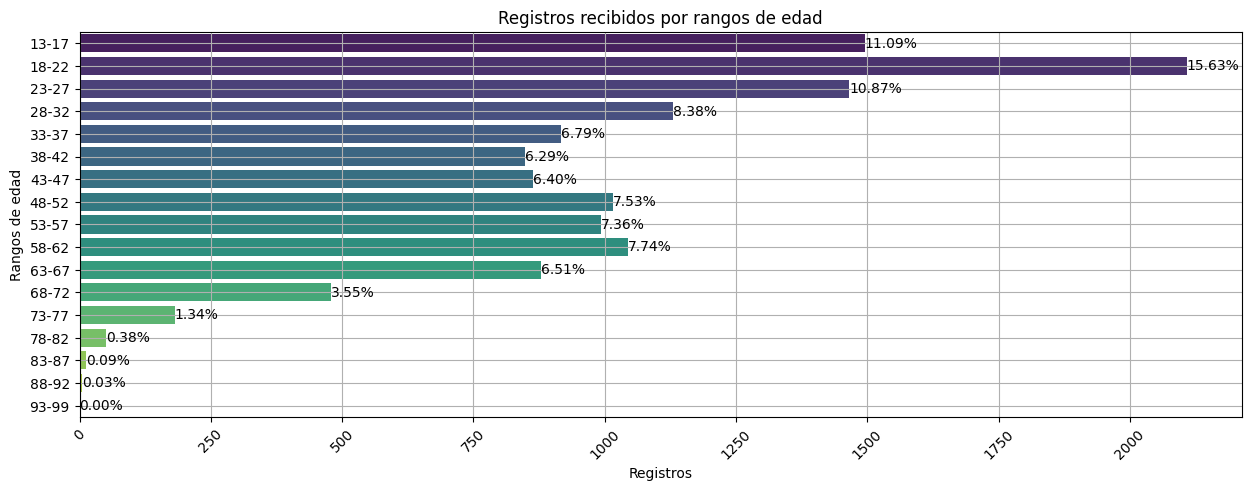

In [23]:
# Crear gráfica de distribución por rangos de edad

total_entries = len(dfTest)
counts = dfTest['rango_edad_c5'].value_counts()
percentage = counts / total_entries * 100

# Definir el nuevo orden deseado
labels = ['13-17', '18-22', '23-27', '28-32', '33-37', '38-42','43-47','48-52','53-57','58-62','63-67','68-72','73-77','78-82','83-87','88-92','93-99']
# Crear la figura
figsize = (15, 5)
plt.figure(figsize=figsize)

# Crear el gráfico de barras con el nuevo orden especificado
sns.barplot(x=counts.values, y=counts.index, order=labels, palette='viridis', dodge=False, hue=counts.index, legend=False)

# Configurar el título y los ejes
plt.title(f'Registros recibidos por rangos de edad')
plt.xlabel('Registros')
plt.ylabel('Rangos de edad')
plt.xticks(rotation=45)
plt.grid(True)

# Añadir los valores de porcentaje en las barras en el nuevo orden correcto
for i, label in enumerate(labels):
    # Encontrar el índice del label en el índice de counts
    index = counts.index.get_loc(label)
    plt.text(counts.values[index], i, f'{percentage[label]:.2f}%', fontsize=10, va='center')

plt.show()

### **Registros por Género:**

In [24]:
# Enlistar valores de la columna 'Género:' los registros de mayor a menor frecuencia.
dfTest['Género:'].value_counts()

Género:
Masculino     8413
Femenino      4679
Selecciona     197
Otro           195
Name: count, dtype: int64

In [25]:
# Reemplazamos 'selecciona' por NaN en la columna 'Género:', equivalente a valores nulos
dfTest['Género:'].replace('Selecciona', np.nan, inplace=True)

/tmp/ipykernel_32027/75841810.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfTest['Género:'].replace('Selecciona', np.nan, inplace=True)


In [26]:
# Contar la cantidad de valores nulos en columna 'Género:' y calcular su porcentaje
cantidad_nulos = dfTest['Género:'].isnull().sum()
cantidad_no_nulos = dfTest['Género:'].notnull().sum()
print(f'Conteo de nulos:{cantidad_nulos}, Conteo de no_nulos:{cantidad_no_nulos}')
pcntg_nulos = cantidad_nulos/len(dfTest)*100
pcntg_no_nulos = cantidad_no_nulos/len(dfTest)*100
print(f'Porcentaje de nulos: {pcntg_nulos:.2f}%, Porcentaje de no_nulos: {pcntg_no_nulos:.2f}%')

Conteo de nulos:197, Conteo de no_nulos:13287
Porcentaje de nulos: 1.46%, Porcentaje de no_nulos: 98.54%


/tmp/ipykernel_32027/2206201652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])


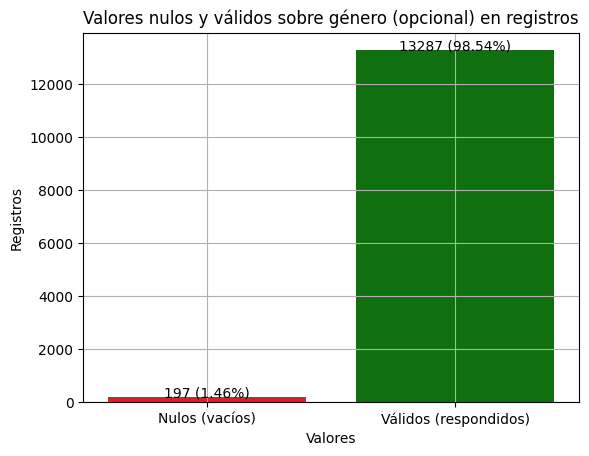

In [27]:
# Visualizar gráfica de valores nulos y válidos en columna 'Género:'
sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])
plt.xlabel('Valores')
plt.ylabel('Registros')
plt.title('Valores nulos y válidos sobre género (opcional) en registros')

# Agregar porcentajes encima de las barras
for i, valor in enumerate([cantidad_nulos, cantidad_no_nulos]):
    if i == 0:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_nulos:.2f}%)', ha='center')
    else:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_no_nulos:.2f}%)', ha='center')

plt.grid()
plt.show()

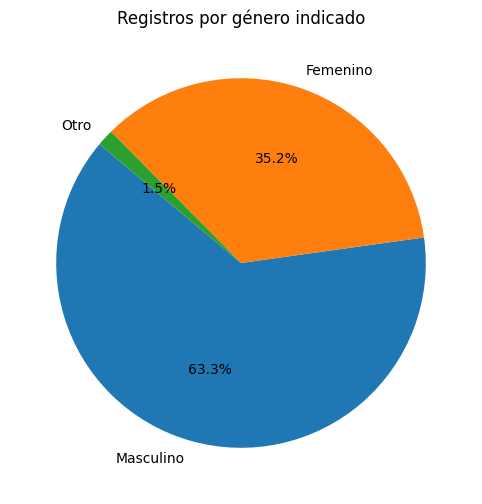

In [28]:
# Visualizar distribución entre registros donde se indicó el género entre las opciones ofrecidas ('Masculino', 'Femenino' y 'Otro')
column='Género:'
figsize=(8,6)
plt.figure(figsize=(8, 6))
dfTest[column].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title(f'Registros por género indicado')
plt.ylabel('')
plt.show()

### **Registros por Grupos en Situación de Discriminación:**

In [29]:
# Enlistar valores de la columna GSD en los registros de mayor a menor frecuencia.

dfTest['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'].value_counts()

¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?
Selecciona                                        7777
Personas adultas mayores                          2251
Personas de la diversidad sexual                  1472
Personas con discapacidad                          864
Personas indígenas                                 664
Personas mexicanas residentes en el extranjero     191
Personas migrantes                                 142
Personas afromexicanas                             123
Name: count, dtype: int64

In [ ]:
# Reemplazar 'selecciona' por NaN en la columna 'GSD'
dfTest['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'].replace('Selecciona', np.nan, inplace=True)

In [31]:
# Contar la cantidad de nulos y calcular su porcentaje
cantidad_nulos = dfTest['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'].isnull().sum()
cantidad_no_nulos = dfTest['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'].notnull().sum()
print(f'Conteo de nulos:{cantidad_nulos}, Conteo de no_nulos:{cantidad_no_nulos}')
pcntg_nulos = cantidad_nulos/len(dfTest)*100
pcntg_no_nulos = cantidad_no_nulos/len(dfTest)*100
print(f'Porcentaje de nulos: {pcntg_nulos:.2f}%, Porcentaje de no_nulos: {pcntg_no_nulos:.2f}%')

Conteo de nulos:7777, Conteo de no_nulos:5707
Porcentaje de nulos: 57.68%, Porcentaje de no_nulos: 42.32%


/tmp/ipykernel_32027/2166377371.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])


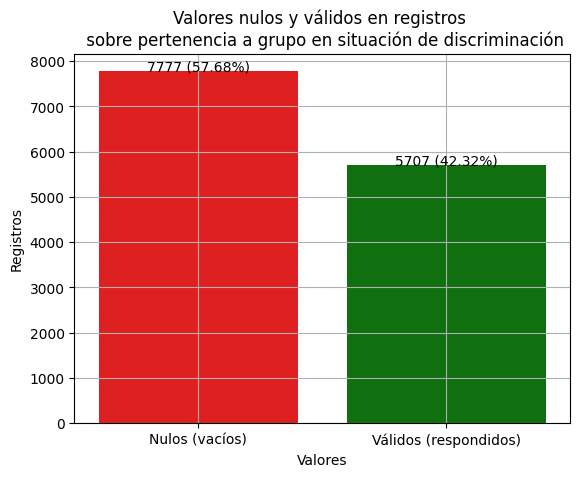

In [32]:
# Visualizar gráfica de valores nulos y válidos en campo (opcional) de pertenencia a Grupo en Situación de Discriminación
sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])
plt.xlabel('Valores')
plt.ylabel('Registros')
plt.title('Valores nulos y válidos en registros \n sobre pertenencia a grupo en situación de discriminación')

#agregar los porcentajes
for i, valor in enumerate([cantidad_nulos, cantidad_no_nulos]):
    if i == 0:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_nulos:.2f}%)', ha='center')
    else:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_no_nulos:.2f}%)', ha='center')

plt.grid()
plt.show()

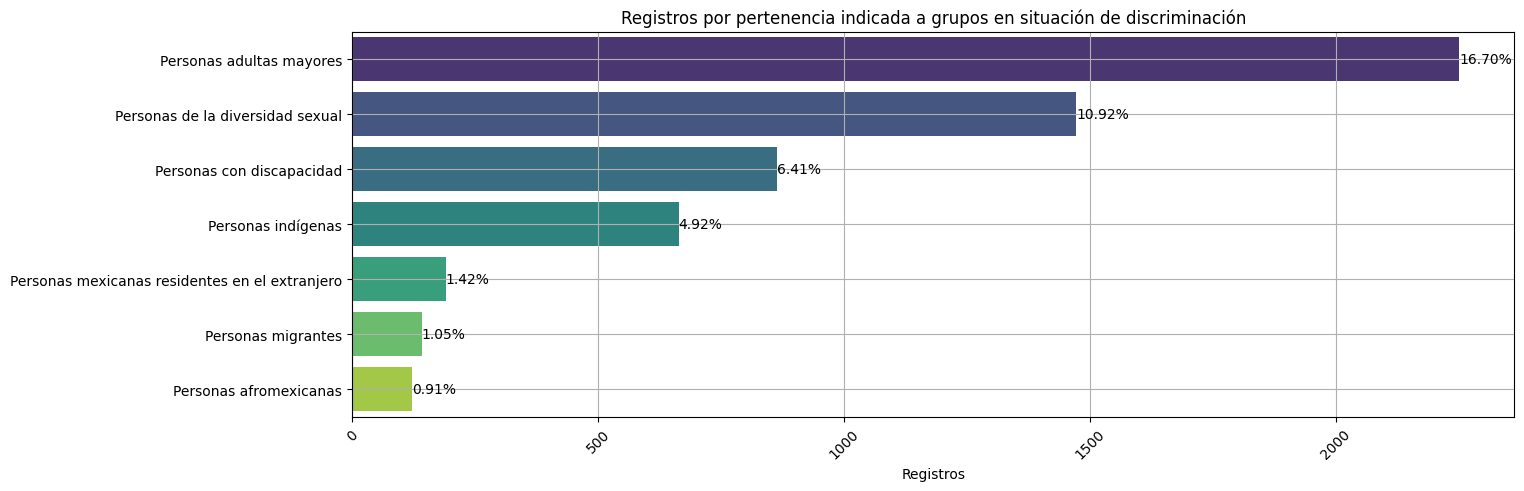

In [33]:
# Calcula el porcentaje de cada grupo
total_entries = counts.sum()
counts = dfTest['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'].value_counts()
percentage = counts / total_entries * 100

# Crear gráfica de registros por pertenencia indicada a grupo en situación de discriminación
column = '¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'
figsize = (15, 5)
plt.figure(figsize=figsize)
sns.barplot(x=counts.values, y=counts.index,  palette='viridis', dodge=False, hue=counts.index, legend=False)
plt.title(f'Registros por pertenencia indicada a grupos en situación de discriminación')
plt.xlabel('Registros')
plt.ylabel('')
plt.xticks(rotation=45)
plt.grid(True)

# Añadir los valores de porcentaje en las barras
for i, val in enumerate(percentage):
    plt.text(counts.values[i], i, f'{val:.2f}%', fontsize=10, va='center')

plt.show()

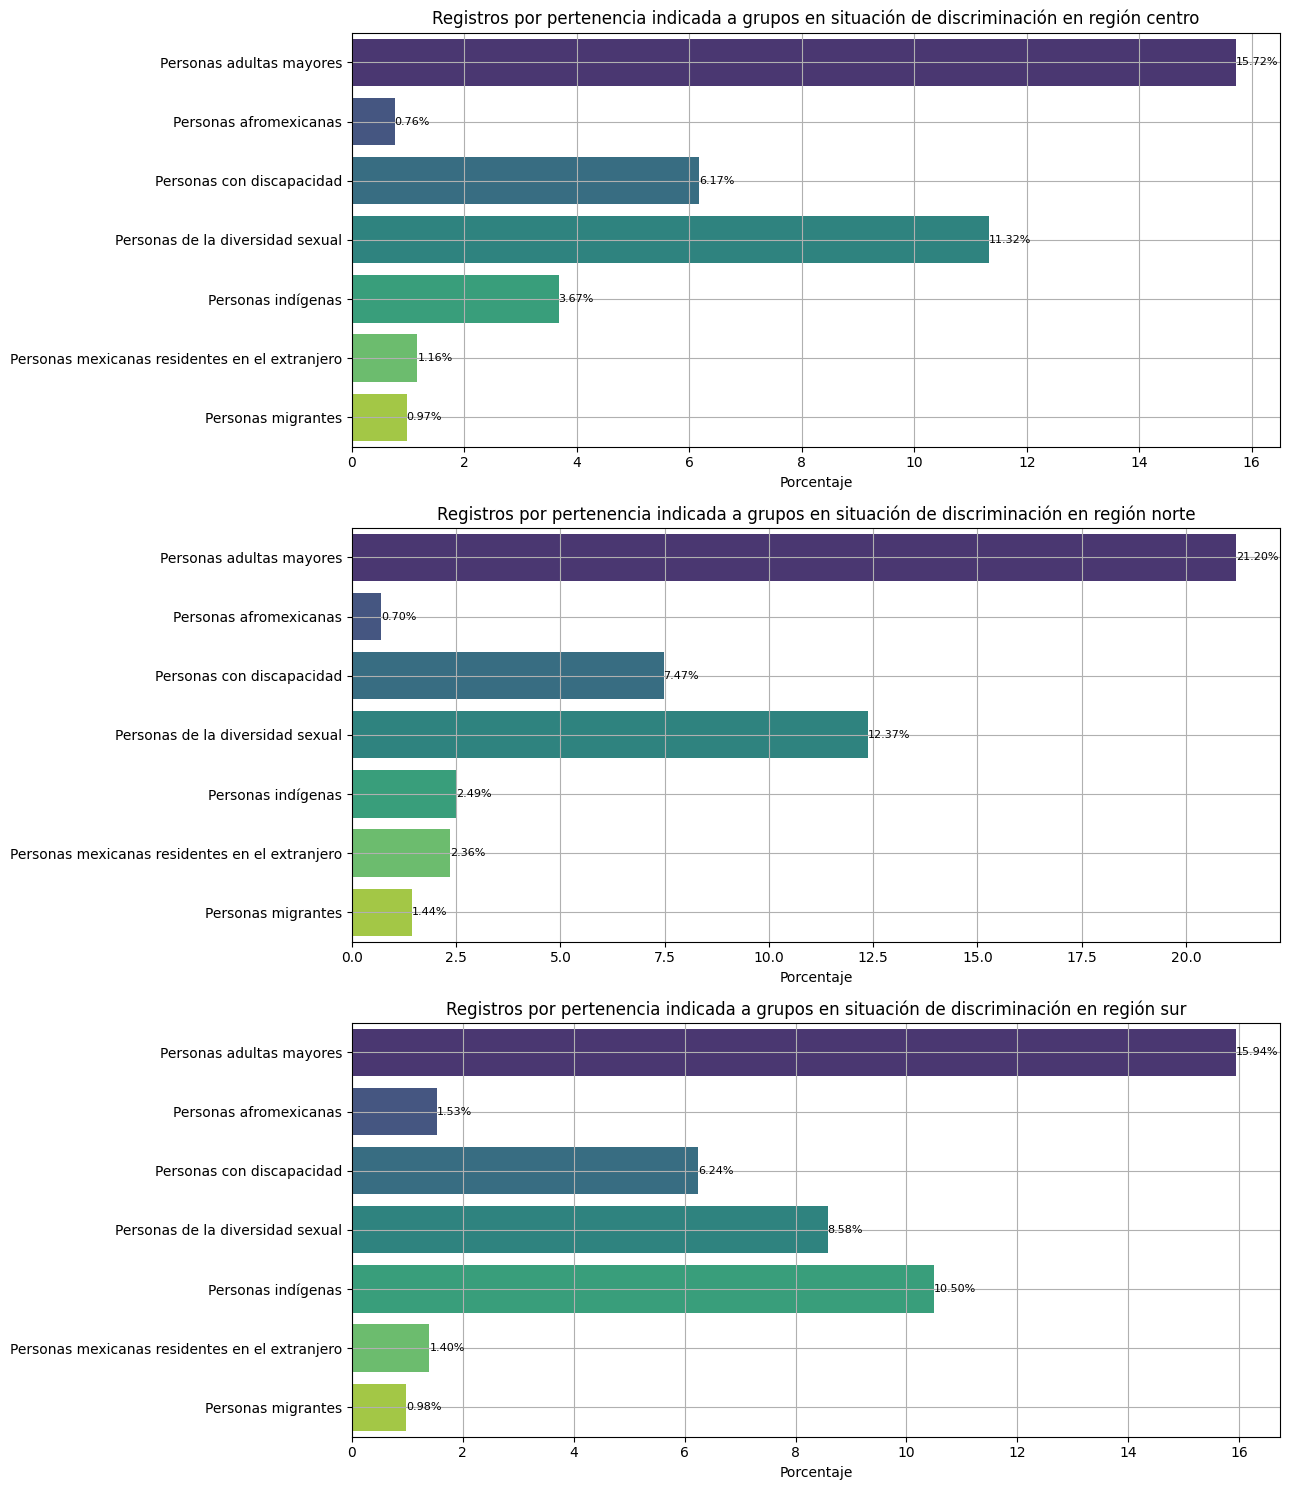

In [34]:
# Crear gráficas de porcentajes de registros por región por pertenencia indicada a grupo en situación de discriminación (opcional)
total_entries_region = dfTest.groupby('region').size()
counts_region = dfTest.groupby(['region', '¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?']).size().unstack(fill_value=0)
percentage_region = counts_region.div(total_entries_region, axis=0) * 100

# Crear gráficas para cada región
fig, axes = plt.subplots(nrows=len(percentage_region), figsize=(13, 5 * len(percentage_region)))
fig.subplots_adjust(hspace=0.5)

for i, (region, data) in enumerate(percentage_region.iterrows()):
    sorted_data = data
    ax = sns.barplot(x=sorted_data.values, y=sorted_data.index, hue=sorted_data.index, palette='viridis', ax=axes[i], legend=False)
    ax.set_title(f'Registros por pertenencia indicada a grupos en situación de discriminación en región {region}')
    ax.set_xlabel('Porcentaje')
    ax.set_ylabel('')
    ax.grid(True)

    # Añadir valores de porcentaje a cada barra
    for j, val in enumerate(sorted_data.values):
        ax.text(val, j, f'{val:.2f}%', fontsize=8, va='center')

plt.tight_layout()
plt.show()

### **Registros por fecha de entrada:**

In [35]:
# Crear copia de trabajo de tabla de registros para procesamiento de fechas
dfTest1 = dfTest.copy()

In [36]:
# Función para convertir la cadena de fecha y hora en un objeto datetime, que toma el valor de 'Fecha de entrada', bajo su formato original'Día Mes, Año Hora AM/PM' en español
def strToDate(strDate):
    meses = {
        "enero,": 1,
        "febrero,": 2,
        "marzo,": 3,
        "abril,": 4,
        "mayo,": 5,
        "junio,": 6,
        "julio,": 7,
        "agosto,": 8,
        "septiembre,": 9,
        "octubre,": 10,
        "noviembre,": 11,
        "diciembre,": 12
    }

    arrStr = strDate.split(" ")
    day = int(arrStr[0])
    month = int(meses[arrStr[1]])
    year = int(arrStr[2])
    x = datetime(year, month, day)
    return x

# Aplicar la función de conversión a la columna 'Fecha de entrada'
dfTest1['Fecha de entrada'] = dfTest1['Fecha de entrada'].apply(strToDate)

# Filtrar las filas que tienen fechas válidas
dfFechasProcesadas = dfTest1.dropna(subset=['Fecha de entrada'])

In [ ]:
# Previsualizar tablas de registros con fechas procesadas
dfFechasProcesadas.head(3)

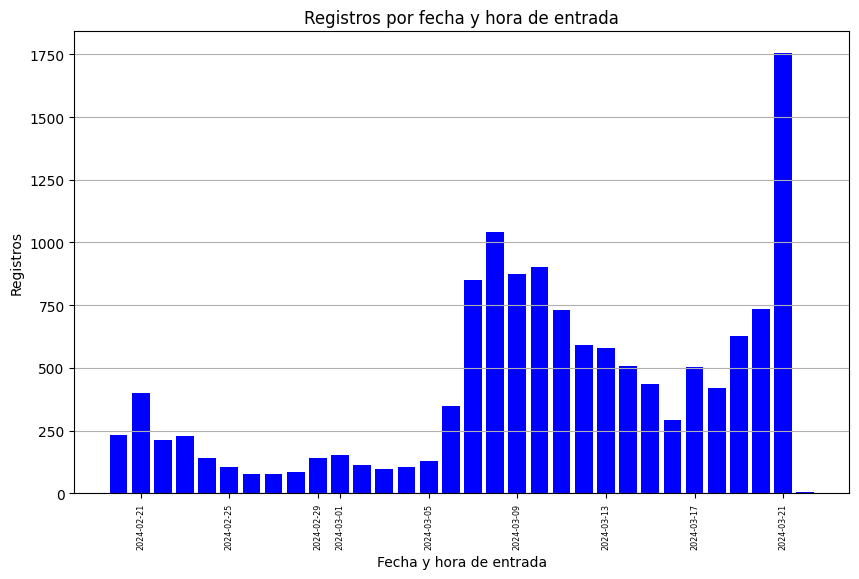

In [38]:
# Crear gráfica de registros por fecha y hora de entrada
plt.figure(figsize=(10, 6))
conteo_fechas = dfFechasProcesadas['Fecha de entrada'].value_counts().sort_index()
fechas_ordenadas = conteo_fechas.index
frecuencias = conteo_fechas.values

plt.bar(fechas_ordenadas, frecuencias, color='blue')
plt.title('Registros por fecha y hora de entrada')
plt.xlabel('Fecha y hora de entrada')
plt.ylabel('Registros')
plt.xticks(rotation=90, fontsize= 'xx-small')
plt.grid(axis='y')
plt.show()

In [39]:
# Contar e imprimir frecuencias de fechas entrada de registros
conteo_fechas = dfTest1['Fecha de entrada'].value_counts().sort_index()
conteo_fechas

Fecha de entrada
2024-02-20     231
2024-02-21     402
2024-02-22     213
2024-02-23     227
2024-02-24     140
2024-02-25     104
2024-02-26      77
2024-02-27      76
2024-02-28      87
2024-02-29     139
2024-03-01     151
2024-03-02     112
2024-03-03      97
2024-03-04     104
2024-03-05     128
2024-03-06     350
2024-03-07     849
2024-03-08    1040
2024-03-09     874
2024-03-10     903
2024-03-11     732
2024-03-12     590
2024-03-13     581
2024-03-14     506
2024-03-15     435
2024-03-16     292
2024-03-17     503
2024-03-18     420
2024-03-19     628
2024-03-20     735
2024-03-21    1754
2024-03-22       4
Name: count, dtype: int64

---

## 3. Extracción y limpieza de preguntas contenidas en registros recibidos

**Generar identificadores únicos (ID) por pregunta**

Formato para ID: xxxxxx_n

Rango de IDs: 000001_n - 024000_n
- xxxxxx -> refiere al registro
- _n -> refiere al número de pregunta de un mismo registro

In [40]:
# Definir función para extraer preguntas de registros recibidos y generar IDs
def transform_dataset(df):
    # Ordenar el DataFrame por la columna de fecha de entrada
    df_sorted = df.sort_values(by='Fecha de entrada')
    print(df_sorted.shape)
    
    # Contador para asignar IDs únicos
    question_id = 1
    transformed_df = []
    
    # Iterar sobre las filas del DataFrame ordenado
    for index, row in df_sorted.iterrows():
        # Agregar la primera pregunta
        new_row = {
            'id': f'{question_id:06d}_1',
            'entidad': row['¿Cuál es tu entidad de origen?'],
            'edad': row['Edad:'],
            'genero': row['Género:'],
            'grupos_discriminacion': 'Ninguno' if row['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'] == 'Selecciona' else row['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'],
            'tema': row['Indica el tema de tu pregunta:'],
            'pregunta': row['Escribe tu pregunta:']
        }
        transformed_df.append(new_row)

        # Iterar sobre las columnas de preguntas a partir de la segunda
        for i in range(2, 7): # Ahora iteramos de 2 a 7 para cubrir todas las preguntas a partir de la segunda
            # Verificar si el usuario desea agregar otra pregunta
            colAgregarPegunta = '¿Deseas agregar otra pregunta?' if i == 2 else f'¿Deseas agregar otra pregunta? ({i-1})'
            if row[colAgregarPegunta] == 'Sí':
                # Crear una nueva fila con los metadatos y la pregunta
                new_row = {
                    'id': f'{question_id:06d}_{i}',
                    'entidad': row['¿Cuál es tu entidad de origen?'],
                    'edad': row['Edad:'],
                    'genero': row['Género:'],
                    'grupos_discriminacion': 'Ninguno' if row['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'] == 'Selecciona' else row['¿Te identificas con alguno de los siguientes Grupos en Situación de Discriminación?'],
                    'tema': row[f'Indica el tema de tu pregunta: ({i})'],
                    'pregunta': row[f'Escribe tu pregunta: ({i})']
                }

                # Agregar la nueva fila al DataFrame transformado
                transformed_df.append(new_row)

        # Incrementar el contador de ID de pregunta solo si se agregó al menos una pregunta
        if row[f'¿Deseas agregar otra pregunta?'] or row[f'¿Deseas agregar otra pregunta? (2)'] == 'Sí' or row[f'¿Deseas agregar otra pregunta? (3)'] == 'Sí' or row[f'¿Deseas agregar otra pregunta? (4)'] == 'Sí' or row[f'¿Deseas agregar otra pregunta? (5)'] == 'Sí':
            question_id += 1
    
    print(len(transformed_df))
    transformed_df = pd.DataFrame(transformed_df)
    return transformed_df

# Crear un nuevo DataFrame para almacenar las preguntas transformadas
df = transform_dataset(dfFechasProcesadas)

(13484, 24)
24000


In [ ]:
# Previsualizar tabla de preguntas con IDs generados
df.head(10)

In [42]:
# Revisar el número de filas y columnas en tabla de preguntas con IDs generados
df.shape

(24000, 7)

### Limpieza de texto sin aporte semántico:

In [43]:
# Definir función para limpiar usuarios, hashtags y URLs
def limpiar_texto(texto):
  """
  Elimina usuarios, hashtags y URLs de un texto.

  Args:
      texto (str): El texto a limpiar.

  Returns:
      str: El texto limpio.
  """
  # Eliminar usuarios
  texto = re.sub(r"(?<!\w)@(\w+)(?!\w)", "", texto)

  # Eliminar hashtags
  texto = re.sub(r"(?<!\w)#(\w+)(?!\w)", "", texto)

  # Eliminar URLs
  texto = re.sub(r"(http|https|ftp)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", "", texto)
  texto = texto.lstrip(". ")

  return texto.strip()

**Ejecutar funciones y agregar nueva columna con preguntas con texto limpio:**

In [44]:
# Definir función para agregar nueva columna con texto limpio (clean_text)
def agregarCleanTextADf(df, colText):
    dfW = df.copy()
    dfW["clean_text"] = None

    for index, row in dfW.iterrows():
        text = str(row[colText])
        cleaned_text = limpiar_texto(text)
        dfW.at[index, "clean_text"] = cleaned_text

    return dfW

In [45]:
# Ejecutar limpieza de usuarios, hashtags y URLs
dfCleanText = agregarCleanTextADf(df, "pregunta")

In [ ]:
# Previsualizar tabla con nueva columna de datos limpios (clean_text)
dfCleanText.head()

### Eliminar palabras vacías (*stop words*):

Descargar dependencias de librería NLTK para **limpieza de palabras vacías (*stop words*):**

In [47]:
# Descargar las stop words en español e inglés
nltk.download('punkt')
nltk.download('stopwords')

# Lista de stopwords en español
stopwords_es = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package punkt to /home/estacion/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/estacion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Función para eliminar palabras vacías (*stop words*)**

In [48]:
# Definir función para eliminar palabras vacías (stopwords)
def delete_stopwords(texto):
  """
  Elimina signos y stop words del texto.

  Args:
      texto (str): El texto a limpiar.

  Returns:
      str: El texto limpio.
  """
  # Tokenizar el texto
  tokens = nltk.word_tokenize(texto)

  # Eliminar signos de puntuación
  tokens = [token for token in tokens if token.isalnum()]

  # Eliminar stop words
  tokens = [token for token in tokens if token not in stopwords_es]

  # Convertir la lista de tokens a un string
  texto_limpio = " ".join(tokens)

  return texto_limpio.strip()

Ejecutar funciones y **agregar columna con texto sin *stop words* (sem_text):**

In [49]:
# Definir función para eliminar palabras vacías y agregar nueva columna con el resultado (sem_text)
def agregarSemTextADf(df, colText):
    dfW = df.copy()
    dfW["sem_text"] = None

    for index, row in dfW.iterrows():
        text = row[colText]
        cleaned_text = delete_stopwords(text)
        dfW.at[index, "sem_text"] = cleaned_text

    return dfW

In [50]:
# Ejecutar función para eliminar palabras vacías y agregar nueva columna con el resultado (sem_text)
dfFinal = agregarSemTextADf(dfCleanText, "clean_text")

In [ ]:
# Previsualizar tabla de datos con nueva columna de preguntas con texto sin palabras vacías (sem_text)
dfFinal.head()

In [52]:
# Revisar el número de filas y columnas en tabla de preguntas con texto sin palabras vacías (sem_text)
dfFinal.shape

(24000, 9)

In [53]:
# Exportar archivo CSV con tabla de 24,000 preguntas con IDs y texto sin palabras vacías (sem_text) 
dfFinal.to_csv(f"{nombreArchivo.split('.')[0]}_PoblacionPreguntasTotales_SinDepurar.csv")

## 4. Depuración de preguntas desde diccionarios con términos de descarte y por repeticiones







A partir de los criterios de elegibilidad de preguntas, definidos por el INE, se desarrollaró un diccionarios especializados, con 519 términos de descarte para realizar la **depuración inicial de preguntas que no cumplan con los siguientes requisitos:**


*  *“La redacción de las preguntas no debe incluir: discursos de odio, inclinación partidista, ideológica, religiosa o cualquier manifestación de violencia o discriminación, o referirse a algún logro de gobierno y/o propaganda gubernamental.”*
* *“Las preguntas deben redactarse de forma general y abierta, y no estar dirigidas a una candidatura específica.”*

*Anexo I. Metodología Selección de Preguntas para Debate Formato A (INE, 2024)*

El diccionario aplicado fue desarrollado por el equipo humano de Signa_Lab ITESO, tras la revisión de diccionarios similares previos externos (Guzmán, 2018), de desarrollo propio (Signa_Lab, 2022) y de conjuntos de datos masivos de redes sociales con presencia de discursos violentos en español, además de la inclusión de términos que pudieran introducir menciones directas a candidaturas, sesgo partidista, ideológico o religioso. La cantidad de términos en la versión final del diccionario se consolidó después de distintas rondas de depuración de las 24,000 preguntas yla revisión manual de los resultados de las mismas para la identificación de falsos negativos y falsos positivos.

**Previsualizar diccionario de descarte importado:**

In [54]:
# Previsualizar tabla de diccionario con términos de descarte
dfDescarte.head(10)

,palabra,tipo,categoría,diccionario
0,alcahueta,palabra,ofensa-violencia,ofensivos-violencia
1,alcahuete,palabra,ofensa-violencia,ofensivos-violencia
2,amargada,palabra,ofensa-violencia,ofensivos-violencia
3,amarrenla,palabra,ofensa-violencia,ofensivos-violencia
4,arguendera,palabra,ofensa-violencia,ofensivos-violencia
5,arguendero,palabra,ofensa-violencia,ofensivos-violencia
6,babosa,palabra,ofensa-violencia,ofensivos-violencia
7,babosas,palabra,ofensa-violencia,ofensivos-violencia
8,babosos,palabra,ofensa-violencia,ofensivos-violencia
9,babos0,palabra,ofensa-violencia,ofensivos-violencia


In [55]:
# Revisar el número de filas y columnas en diccionario importado
dfDescarte.shape

(519, 4)

In [56]:
# Definir función para cotejar cada pregunta con términos de descarte, eliminar las coincidencias y agregar su razonamiento en nueva columna
def filtrar_preguntas_pandas(df_preguntas, df_terminos_descarte, colPregunta):
    # Definir los terminos que no deben de estar en las preguntas 
    terminos = df_terminos_descarte["palabra"].tolist()
    # Compilar expresiones regulares una sola vez
    expresiones_regex = [re.compile(r"(?<!\S)?(?:\s|[.,;:?!¡¿]){}(?:\s|[.,;:?!¡¿])?(?!\S)".format(re.escape(termino)), re.IGNORECASE) for termino in terminos]

    # Columnas adicionales
    df_preguntas_filtradas = df_preguntas.copy()
    df_preguntas_filtradas["contiene_termino_descarte"] = False
    df_preguntas_filtradas["razon_eliminacion"] = ""

    # Filtrar preguntas
    for i in range(df_preguntas_filtradas.shape[0]):
        pregunta = str(df_preguntas_filtradas.loc[i, colPregunta]).lower().replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú", "u")

        # Buscar coincidencias con expresiones regulares
        for expresion, razon in zip(expresiones_regex, df_terminos_descarte["categoría"]):
            coincidencias = expresion.findall(f" {pregunta} ")
            if coincidencias or ('presidente' not in pregunta and 'presidenta' in pregunta):
                df_preguntas_filtradas.loc[i, "contiene_termino_descarte"] = True
                df_preguntas_filtradas.loc[i, "razon_eliminacion"] = f"Presencia de términos relacionados a {razon}"
                break
                
    # Eliminar preguntas que contienen términos de descarte
    df_preguntas_eliminadas = df_preguntas_filtradas[df_preguntas_filtradas["contiene_termino_descarte"]]
    df_preguntas_filtradas = df_preguntas_filtradas[~df_preguntas_filtradas["contiene_termino_descarte"]]

    # Eliminar columnas auxiliares
    del df_preguntas_filtradas["contiene_termino_descarte"]
    del df_preguntas_filtradas["razon_eliminacion"]
    del df_preguntas_eliminadas["contiene_termino_descarte"]

    df_preguntas_filtradas = df_preguntas_filtradas.reset_index(drop=True)
    
    return df_preguntas_filtradas, df_preguntas_eliminadas


In [57]:
# Ejecutar depuración de preguntas por palabras de descarte en diccionario
datasetSinTerminosProhibidos, datasetPreguntasEliminadasPorDescarte = filtrar_preguntas_pandas(dfFinal, dfDescarte,"pregunta")

In [58]:
# Revisar el número de filas y columnas en tabla de preguntas depuradas por palabras de descarte en diccionario
datasetSinTerminosProhibidos.shape

(22883, 9)

**Tamaño dataset con términos descartados**

In [59]:
# Revisar el número de filas y columnas en tabla de preguntas eliminadas por palabras de descarte en diccionario
datasetPreguntasEliminadasPorDescarte.shape

(1117, 10)

In [60]:
#Verificar eliminación de casos específicos (opcional)
verificar_termino = ""

_count = 0 
for i in datasetPreguntasEliminadasPorDescarte['clean_text']:
    words = i.split()
    if verificar_termino in words:
        _count += 1
_count

0

**Eliminar preguntas repetidas:**

Para responder a la indicación especificada en la metodología, Anexo I (INE, 2024), que solicita evitar repeticiones y eliminar preguntas que correspondan a una misma pregunta, se realizó un análisis de similitud entre preguntas desde su redacción, considerando tanto las palabras repetidas como el orden de las mismas. De esta manera, se eliminan aquellas preguntas que contengan una similitud en su redacción mayor a un umbral establecido, el cual decidió mantener a un 100% por indicaciones del personal del INE, para buscar eliminar preguntas con una repetición exacta.

> *“A partir de esta base de datos, la institución deberá condensar aquellos registros que por
su semántica o sintaxis correspondan a una misma pregunta, a fin de evitar repeticiones.”*

*(Anexo I. Metodología Selección de Preguntas para Debate Formato A)*


In [61]:
# Definir función para calcular la similitud entre dos listas de palabras
def Similarity_Score(list1, list2):
    # Inicializar contadores para coincidencias y longitud total
    matches = 0
    total_length = 0
    
    # Iterar sobre las listas hasta el tamaño de la lista más corta
    for i in range(min(len(list1), len(list2))):
        # Si las palabras en las mismas posiciones coinciden, incrementar el contador de coincidencias
        if list1[i] == list2[i]:
            matches += 1
        # Incrementar el contador de longitud total
        total_length += 1
    
    # Para las posiciones adicionales en la lista más larga, incrementar el contador de longitud total
    for i in range(min(len(list1), len(list2)), max(len(list1), len(list2))):
        total_length += 1
    
    # Calcular el ratio de coincidencias como la proporción de coincidencias sobre la longitud total
    ratio = matches / total_length
    
    return ratio

**Definir función para identificar preguntas repetidas:**

In [62]:
def remove_duplicates_with_threshold(df, column, threshold):
    global similarity_score
    print("Se actualizó")
    indices_to_remove = set()
    question_frequency = defaultdict(int) # Diccionario para almacenar la frecuencia de preguntas similares
    discarded_info = defaultdict(list) # Diccionario para almacenar información de preguntas descartadas

    # Crear índice invertido para las palabras en las preguntas
    inverted_index = defaultdict(set)
    for i, question in enumerate(df[column]):
        words = set(question.split())
        for word in words:
            inverted_index[word].add(i)
    
    print(f"{len(df[column])} preguntas en total")
    for i, question in enumerate(df[column]):
        if i not in indices_to_remove:
            similar_questions_count = 1 # Contador de preguntas similares para la fila actual
            words = set(question.split())
            relevant_indices = set()
            for word in words:
                relevant_indices |= inverted_index[word]

            for j in relevant_indices:
                if j != i and j not in indices_to_remove:
                    preguntaSinAcentos = question.replace('á', 'a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
                    preguntaSinAcentosEnLista = preguntaSinAcentos.split(" ")
                    preguntaAComparar = df[column][j]
                    pregACompararSinAcentos = preguntaAComparar.replace('á', 'a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
                    preguntaACompararEnLista = pregACompararSinAcentos.split(" ")
                    
                    score = Similarity_Score(list(preguntaSinAcentosEnLista), list(preguntaACompararEnLista))
                    if score >= threshold:
                        indices_to_remove.add(j)
                        similar_questions_count += 1
                        # Almacenar información de la pregunta descartada
                        discarded_info[j].append({'original_index': df['id'][i], 'similarity_score': score})
            question_frequency[i] = similar_questions_count # Almacenar la frecuencia de preguntas similares para la fila actual
            
        if i % 1000 == 0:
            print(f"Van {i} preguntas revisadas...")
                
    # Eliminar los registros duplicados después de completar el bucle
    filtered_df = df.drop(indices_to_remove).reset_index(drop=True)

    # Crear DataFrame con registros duplicados
    df_removed_duplicates = df.iloc[list(indices_to_remove)]

    # Agregar información de preguntas descartadas al DataFrame de preguntas descartadas
    id_match = []
    similarity_score = []
    
    # Iterar sobre índice de DataFrame
    for index in df_removed_duplicates.index:
        # Revisar si el índice se encuentra en discarded_info
        if index in discarded_info:
            # Por cada índice, toma el primer elemento de 'original_index' y 'similarity_score'
            id_match.append(discarded_info[index][0]['original_index'])
            similarity_score.append(discarded_info[index][0]['similarity_score'])
        else:
            # Si el índice no está en discarded_info, agregar el valor por default None
            id_match.append(None)
            similarity_score.append(None)

    df_removed_duplicates['id_match'] = id_match
    df_removed_duplicates['similarity_score'] = similarity_score
    
    filtered_df['question_frequency_count'] = filtered_df['id'].apply(
        lambda x: len(df_removed_duplicates[df_removed_duplicates['id_match'] == x]) + 1)

    return filtered_df, df_removed_duplicates

Ejecutar función para **eliminar preguntas duplicadas**

In [63]:
# Establecer umbral de similitud (porcentaje)
threshold = 1 # Se eliminan preguntas que sean 100% similares en su redacción a alguna ya registrada
# Ejecutar elminación de preguntas repetidas
df_filtered, df_removed_duplicates = remove_duplicates_with_threshold(datasetSinTerminosProhibidos, 'sem_text', threshold)#.head(1000)

Se actualizó
22883 preguntas en total
Van 0 preguntas revisadas...
Van 1000 preguntas revisadas...
Van 2000 preguntas revisadas...
Van 3000 preguntas revisadas...
Van 4000 preguntas revisadas...
Van 5000 preguntas revisadas...
Van 6000 preguntas revisadas...
Van 7000 preguntas revisadas...
Van 8000 preguntas revisadas...
Van 9000 preguntas revisadas...
Van 10000 preguntas revisadas...
Van 11000 preguntas revisadas...
Van 12000 preguntas revisadas...
Van 13000 preguntas revisadas...
Van 14000 preguntas revisadas...
Van 15000 preguntas revisadas...
Van 16000 preguntas revisadas...
Van 17000 preguntas revisadas...
Van 18000 preguntas revisadas...
Van 19000 preguntas revisadas...
Van 20000 preguntas revisadas...
Van 21000 preguntas revisadas...
Van 22000 preguntas revisadas...


/tmp/ipykernel_32027/377710362.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_duplicates['id_match'] = id_match
/tmp/ipykernel_32027/377710362.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_duplicates['similarity_score'] = similarity_score


In [ ]:
# Previsualizar tabla de población de preguntas depuradas con la frecuencia de aparición de cada pregunta respecto a otras preguntas
df_filtered.head()

In [ ]:
# Previsualizar tabla de preguntas eliminadas por repetición
df_removed_duplicates.head()

In [ ]:
# Definir función para agregar la razón de eliminación por repetidos
def agregar_razon_eliminacion(df_removed, razon):
    df_removed['razon_eliminacion'] = razon
    return df_removed

df_removed_duplicates = agregar_razon_eliminacion(df_removed_duplicates, 'Redacción repetida respecto a otra pregunta')

In [ ]:
# Previsualizar tabla de preguntas eliminadas por repetición con razón de eliminación
df_removed_duplicates

In [68]:
# Revisar el número de filas y columnas en tabla de preguntas eliminadas por repetición
df_removed_duplicates.shape

(1664, 12)

**Concatenar tabla con filas eliminadas por términos de descarte en diccionario y por repeticiones:**

In [69]:
# Ejecutar concatenación de filas eliminadas por términos en diccionario y repeticiones
datasetPreguntasEliminadas = pd.concat([datasetPreguntasEliminadasPorDescarte, df_removed_duplicates], axis=0)

In [ ]:
# Previsualizar tabla de preguntas eliminadas por términos en diccionario y repeticiones con razón de eliminación
datasetPreguntasEliminadas

In [71]:
# Ejecutar asignación de región a cada pregunta en nueva columna
colEntidad = "entidad"
df_filtered = addRegionColumn(df_filtered.copy(), colEntidad)

In [ ]:
# Previsualizar tabla de población de preguntas depuradas
df_filtered

## 5. Revisar y exportar datos con preguntas depuradas y eliminadas

In [73]:
# Revisar el número de filas y columnas en tabla de población de preguntas depuradas
df_filtered.shape

(21219, 11)

In [74]:
# Revisar el número de filas y columnas en tabla concatenada de preguntas eliminadas por términos de descarte en diccionarios y repeticiones
datasetPreguntasEliminadas.shape

(2781, 12)

**Exportar archivo de datos (en formato CSV) de población de preguntas depuradas a utilizar:**

In [75]:
# Ejemplo exportar archivo de datos (CSV) con población de preguntas depuradas
df_filtered.to_csv(f"{nombreArchivo.split('.')[0]}_PoblacionPreguntasDepuradas.csv")

print(f"¡{nombreArchivo.split('.')[0]}_PoblacionPreguntasDepuradas.csv descargado!")

¡PreguntasDebateINE_PoblacionPreguntasDepuradas.csv descargado!


**Exportar archivo de datos (en formato CSV) de preguntas eliminadas por términos de descarte o repeticiones, con su razonamiento correspondiente:**

In [76]:
# Ejemplo exportar archivo de datos (CSV) con preguntas eliminadas por términos de descarte en diccionarios y repeticiones
datasetPreguntasEliminadas.to_csv(f"{nombreArchivo.split('.')[0]}_PreguntasDescartadas.csv")

print(f"¡{nombreArchivo.split('.')[0]}_PreguntasDescartadas.csv descargado!")

¡PreguntasDebateINE_PreguntasDescartadas.csv descargado!


## 6. Análisis Exploratorio de Datos (A.E.D.) de población de preguntas depuradas

### Preguntas por región en población depurada:

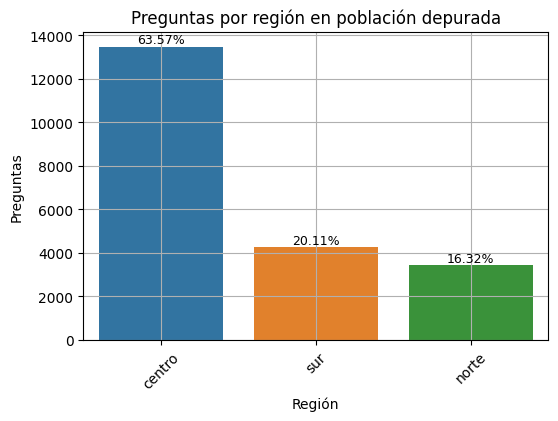

In [77]:
# Contar preguntas y calcular porcentajes por región
total_entries = len(df_filtered)
counts = df_filtered['region'].value_counts()
percentage = counts / total_entries * 100

# Crear gráfica de barras de preguntas por región en población depurada
column = 'region'
figsize = (6, 4) 
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(x=counts.index, y=counts.values, order=counts.index, hue=counts.index, ax=ax)
plt.title(f'Preguntas por región en población depurada')
plt.ylabel('Preguntas')
plt.xlabel('Región')
plt.xticks(rotation=45)
plt.grid(True)

# Añadir los valores de porcentaje en las barras
for index, value in enumerate(counts.values):
    ax.annotate(f'{percentage.iloc[index]:.2f}%', xy=(index, value), ha='center', va='bottom', fontsize=9)

plt.show()


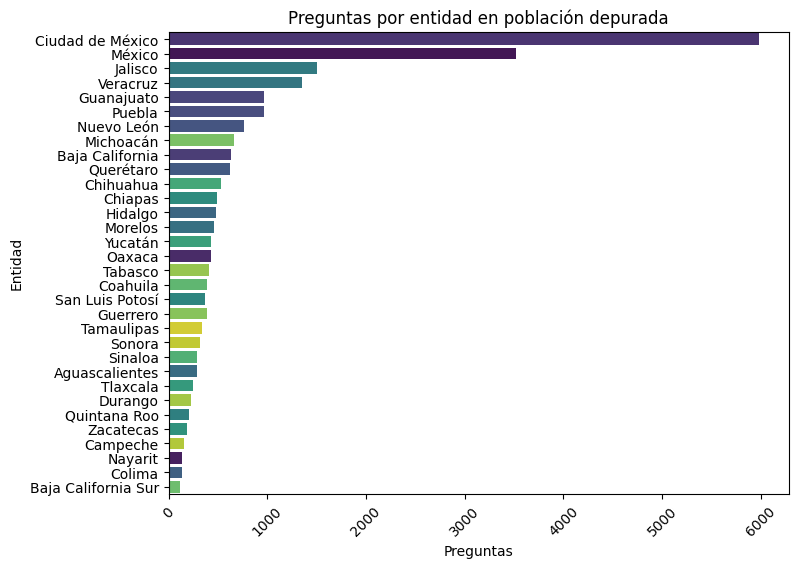

In [78]:
# Crear gráfica de barras de preguntas por entidad en población depurada
column = 'entidad'
figsize = (8,6)
orden = df_filtered[column].value_counts().index
plt.figure(figsize=figsize)
sns.countplot(data=df, y=column, hue=column, palette='viridis', order=orden, legend=False)
plt.title(f'Preguntas por entidad en población depurada')
plt.xlabel('Preguntas')
plt.ylabel('Entidad')
plt.xticks(rotation=45)
plt.show()

In [79]:
# Visualizar tabla con cantidad y porcentaje de preguntas por entidad
tabla(df_filtered,'entidad')

,entidad,Cantidad,Porcentaje
0,Aguascalientes,230,1.08%
1,Baja California,557,2.63%
2,Baja California Sur,98,0.46%
3,Campeche,130,0.61%
4,Chiapas,430,2.03%
5,Chihuahua,468,2.21%
6,Ciudad de México,5296,24.96%
7,Coahuila,344,1.62%
8,Colima,115,0.54%
9,Durango,196,0.92%


### Preguntas por tema en población depurada:

In [80]:
# Enlistar temas y códigos de color
themes = ["Combate a la corrupción", "Educación", "No discriminación y grupos vulnerables", "Salud", "Transparencia", "Violencia en contra de las mujeres"]
topic_color_palette = ["#c1883f", "#7878cd", "#7aa444", "#c45ca2", "#4aad92", "#cc554f"]

# Emparejar cada tema con cada color
topic_color_dict = dict(zip(themes, topic_color_palette))

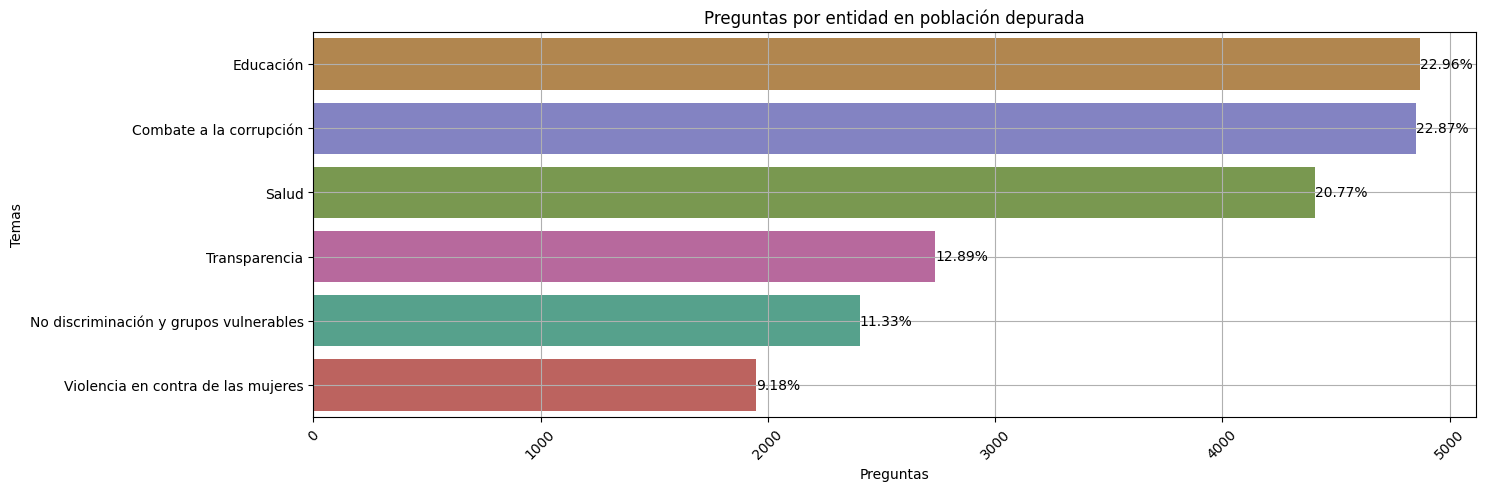

In [81]:
# Contar preguntas por cada tema y calcular porcentajes
total_entries = len(df_filtered)
counts = df_filtered['tema'].value_counts()
percentage = counts / total_entries * 100

sns.set_palette(topic_color_palette)

# Crear gráfica con de barras con preguntas de población depurada por tema
column = 'tema'
figsize = (15, 5)
plt.figure(figsize=figsize)
sns.barplot(x=counts.values, y=counts.index, order=counts.index, dodge=False, hue=counts.index, legend=False)
plt.title('Preguntas por entidad en población depurada')
plt.xlabel('Preguntas')
plt.ylabel('Temas')
plt.xticks(rotation=45)
plt.grid(True)

# Añadir los valores de porcentaje en las barras
for i, val in enumerate(percentage):
    plt.text(counts.values[i], i, f'{val:.2f}%', fontsize=10, va='center')

plt.show()


### Preguntas por tema y por región en población depurada:

/tmp/ipykernel_32027/2316345930.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_32027/2316345930.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_32027/2316345930.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


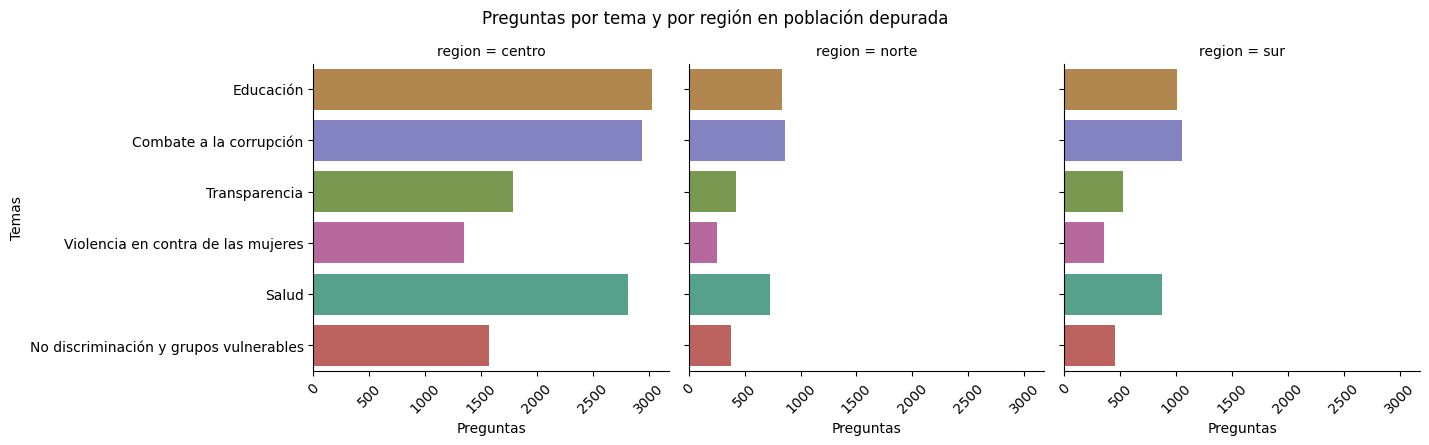

In [82]:
# Crear gráfica múltiple comparativa con preguntas de población depurada por tema y región

sns.set_palette(topic_color_palette)
g = sns.catplot(data=df_filtered, y="tema", hue="tema", col='region', kind='count', legend=False, col_wrap=3, height=4, aspect=1.2)
for ax in g.axes.flat:
    ax.set_xlabel('Preguntas')
    ax.set_ylabel('Temas')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.suptitle(f'Preguntas por tema y por región en población depurada', y=1.05)
plt.show()

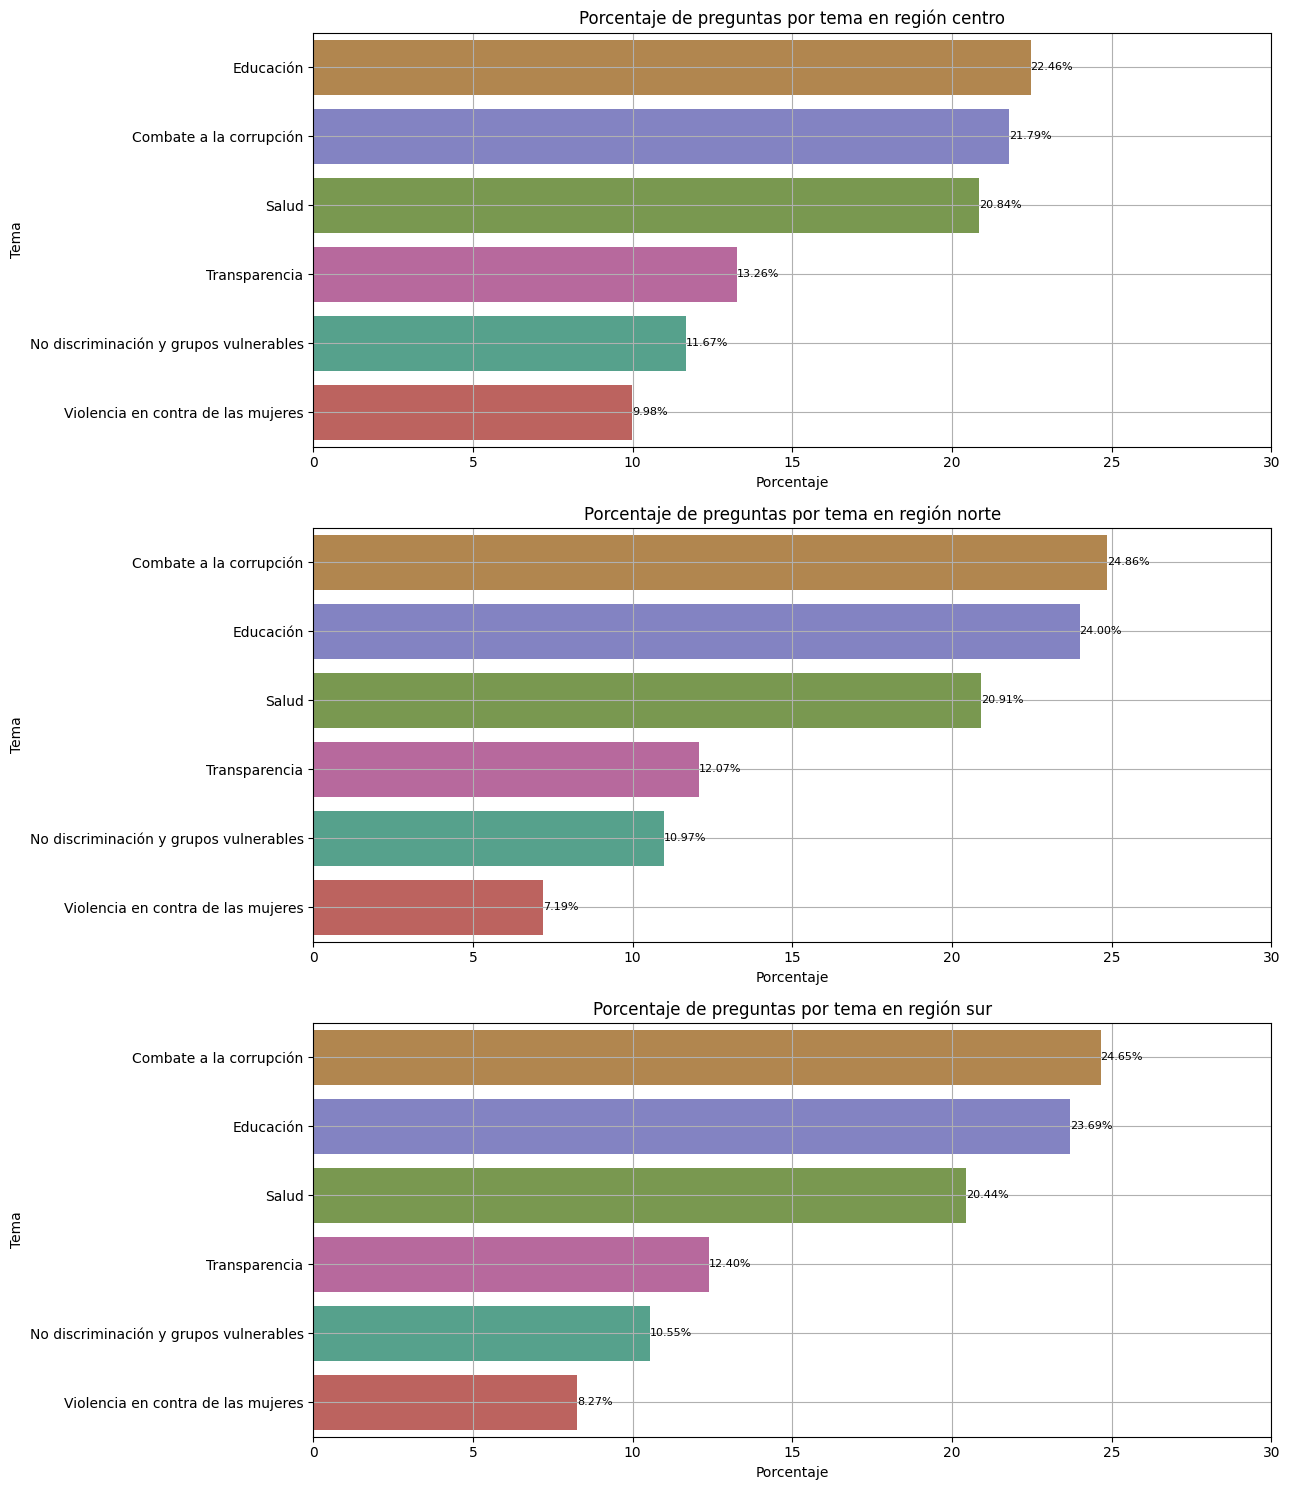

In [83]:
# Crear gráficas con porcentajes de preguntas de población depurada por tema y región
total_entries_region = df_filtered.groupby('region').size()
counts_region = df_filtered.groupby(['region', 'tema']).size().unstack(fill_value=0)
percentage_region = counts_region.div(total_entries_region, axis=0) * 100

# Crear gráficas para cada región
fig, axes = plt.subplots(nrows=len(percentage_region), figsize=(13, 5 * len(percentage_region)))
fig.subplots_adjust(hspace=0.5)

for i, (region, data) in enumerate(percentage_region.iterrows()):
    # Ordenar categorías
    sorted_data = data.sort_values(ascending=False)
    ax = sns.barplot(x=sorted_data.values, y=sorted_data.index, hue=sorted_data.index, ax=axes[i], legend=False, palette=topic_color_palette)
    ax.set_title(f'Porcentaje de preguntas por tema en región {region}')
    ax.set_xlabel('Porcentaje')
    ax.set_ylabel('Tema')
    ax.grid(True)

    # Añadir etiquetas con porcentajes
    for j, val in enumerate(sorted_data.values):
        ax.text(val, j, f'{val:.2f}%', fontsize=8, va='center')

    # Ajustar eje horizontal a rango fijo de 0 a 30%
    ax.set_xlim(0, 30)

plt.tight_layout()
plt.show()

In [84]:
# Visualizar tabla con conteo de preguntas en población depurada por tema y región

# Agrupar por región y tema y contar el número de ocurrencias
counts_region = df_filtered.groupby(['region', 'tema']).size().unstack(fill_value=0)

# Calcular el total por región
counts_region['Total por region'] = counts_region.sum(axis=1)

# Calcular el total por tema
counts_region.loc['Total por tema'] = counts_region.sum(axis=0)

# Mostrar el DataFrame actualizado
counts_region


tema,Combate a la corrupción,Educación,No discriminación y grupos vulnerables,Salud,Transparencia,Violencia en contra de las mujeres,Total por region
region,,,,,,,
centro,2939,3030,1574,2811,1789,1346,13489
norte,861,831,380,724,418,249,3463
sur,1052,1011,450,872,529,353,4267
Total por tema,4852,4872,2404,4407,2736,1948,21219


### Preguntas por edad en población depurada:

In [85]:
# Agregar columna con valor de rango de edad correspondiente a cada pregunta (cada 5 años)
bins = [13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68,73,78,83,88,93,99]
labels = ['13-17', '18-22', '23-27', '28-32', '33-37', '38-42','43-47','48-52','53-57','58-62','63-67','68-72','73-77','78-82','83-87','88-92','93-99']

df_filtered['rango_edad_c5'] = pd.cut(df_filtered['edad'], bins=bins, labels=labels, right=False)

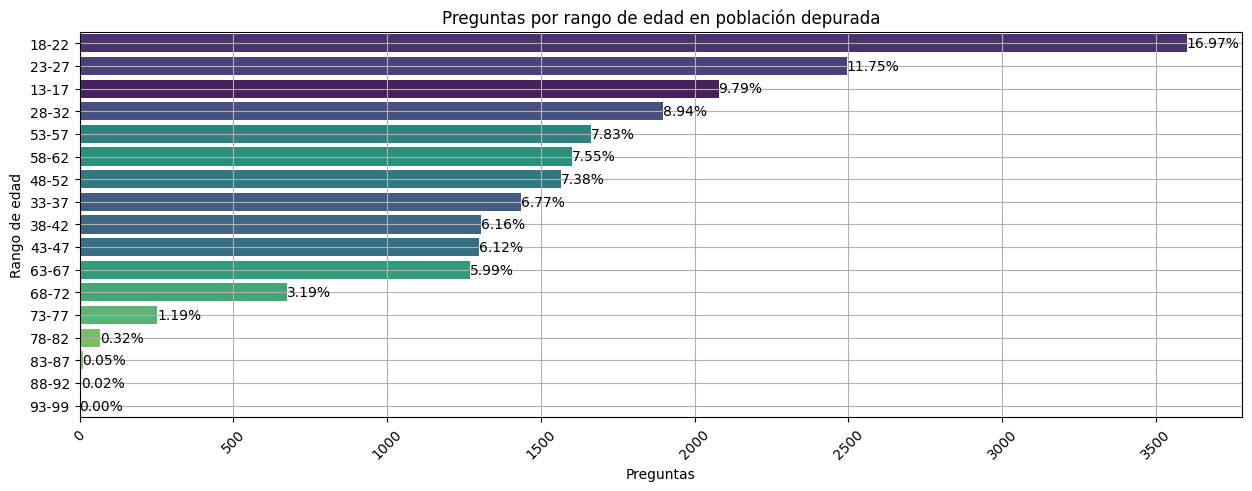

In [86]:
# Calcula el porcentaje de cada tema
total_entries = len(df_filtered)
counts = df_filtered['rango_edad_c5'].value_counts()
percentage = counts / total_entries * 100

# Crear gráfica de barras con preguntas por rango de edad
column = 'rango_edad_c5'
figsize = (15, 5)
plt.figure(figsize=figsize)
sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis', dodge=False, hue=counts.index, legend=False)
plt.title(f'Preguntas por rango de edad en población depurada')
plt.xlabel('Preguntas')
plt.ylabel('Rango de edad')
plt.xticks(rotation=45)
plt.grid(True)

# Añadir los valores de porcentaje en las barras
for i, val in enumerate(percentage):
    plt.text(counts.values[i], i, f'{val:.2f}%', fontsize=10, va='center')

plt.show()

### Preguntas por edad y región en población depurada:

/tmp/ipykernel_32027/785817028.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_region = df_filtered.groupby(['region', 'rango_edad_c5']).size().unstack(fill_value=0)


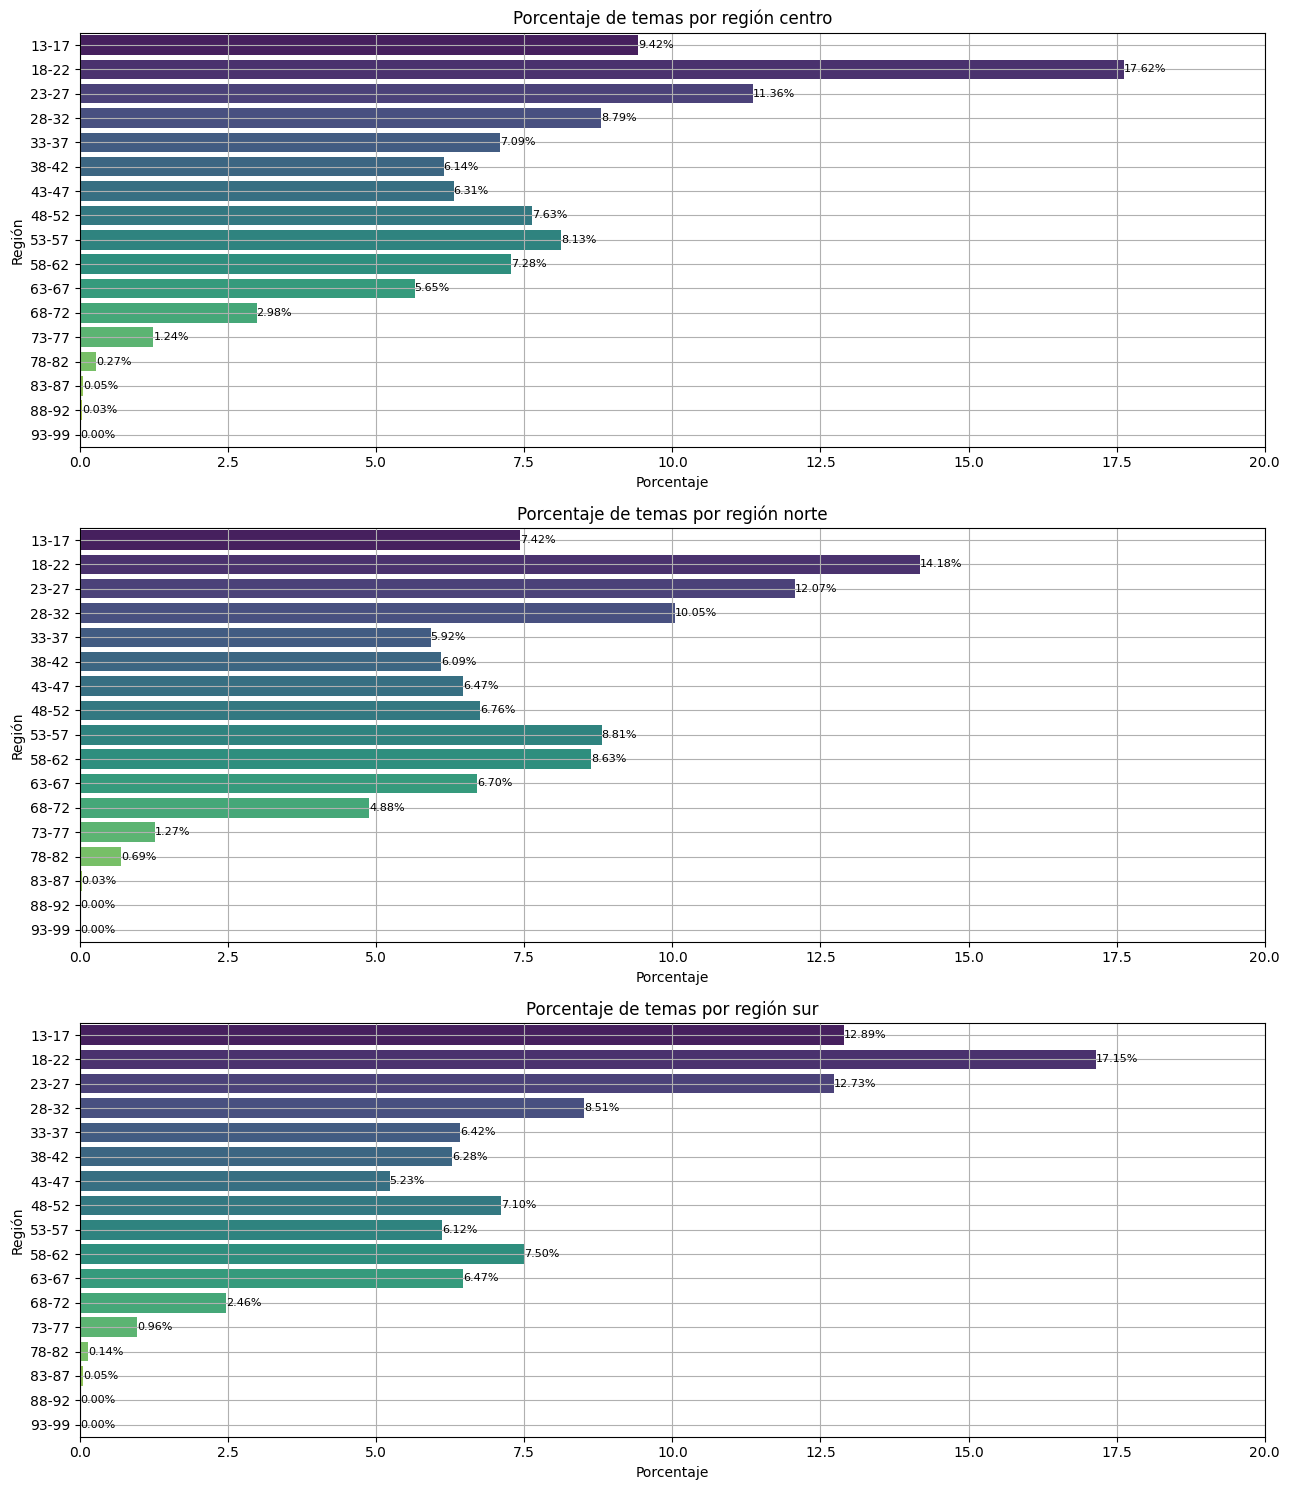

In [87]:
# Calcular porcentaje de rangos de edad en preguntas recibidas por región
total_entries_region = df_filtered.groupby('region').size()
counts_region = df_filtered.groupby(['region', 'rango_edad_c5']).size().unstack(fill_value=0)
percentage_region = counts_region.div(total_entries_region, axis=0) * 100

# Create gráficas de barras para cada región
fig, axes = plt.subplots(nrows=len(percentage_region), figsize=(13, 5 * len(percentage_region)))
fig.subplots_adjust(hspace=0.5)

for i, (region, data) in enumerate(percentage_region.iterrows()):
    sorted_data = data.sort_values(ascending=False)
    ax = sns.barplot(x=sorted_data.values, y=sorted_data.index, hue=sorted_data.index, ax=axes[i], legend=False, palette="viridis")
    ax.set_title(f'Porcentaje de temas por región {region}')
    ax.set_xlabel('Porcentaje')
    ax.set_ylabel('Región')
    ax.grid(True)

    # Añadir porcentaje a etiquetas
    for j, val in enumerate(data.values):
        ax.text(val, j, f'{val:.2f}%', fontsize=8, va='center')

    # Ajustar eje horizontal a rango fijo de 0 a 20%
    ax.set_xlim(0, 20)

plt.tight_layout()
plt.show()

### Preguntas por edad y tema en población depurada:

/tmp/ipykernel_32027/2126889771.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_filtered.pivot_table(index='rango_edad_c5', columns='tema', aggfunc='size', fill_value=0)


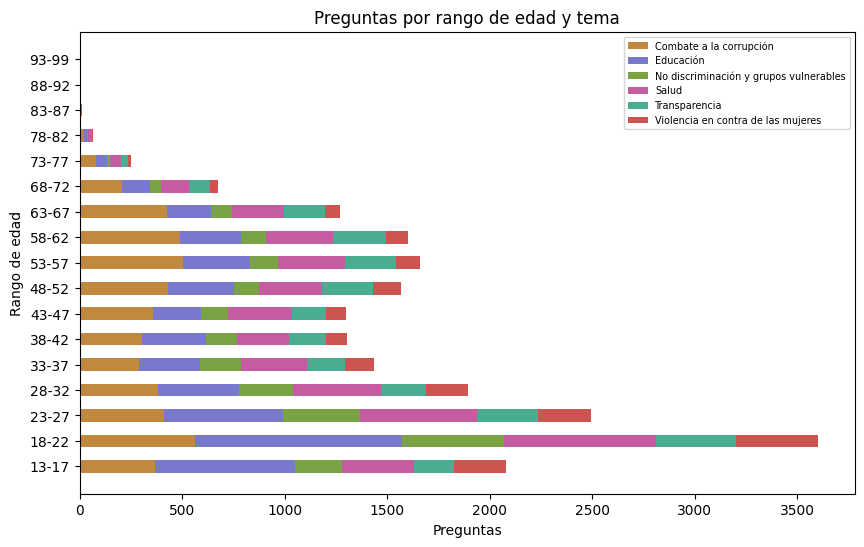

In [88]:
# Crear gráfica de barras apilada de preguntas por rango de edad y tema en población depurada
pivot_df = df_filtered.pivot_table(index='rango_edad_c5', columns='tema', aggfunc='size', fill_value=0)

fig, ax = plt.subplots(figsize= (10,6))
barWidth = 0.5

for i, col in enumerate(pivot_df.columns):
    ax.barh(pivot_df.index, pivot_df[col], height=barWidth, left=np.sum(pivot_df.iloc[:, :i], axis=1), label=col, color=topic_color_palette[i % len(topic_color_palette)])

plt.xlabel('Preguntas')
plt.ylabel('Rango de edad')
plt.title('Preguntas por rango de edad y tema')
plt.yticks(rotation=0) 
plt.legend(fontsize='x-small', loc='upper right')
plt.show()

### Preguntas por género en población depurada:

/tmp/ipykernel_32027/3777432696.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])


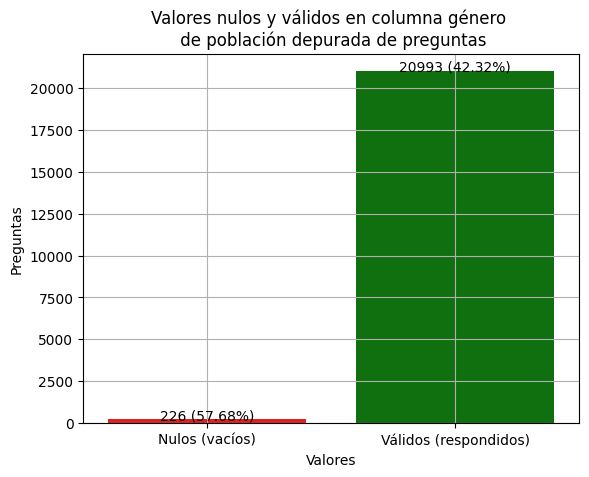

In [89]:
# Contar preguntas con valores nulos (vacías) y válidos (respondidas) en campo (opcional) género
cantidad_nulos = df_filtered['genero'].isnull().sum()
cantidad_no_nulos = df_filtered['genero'].notnull().sum()

# Crear gráfica de barras con valores nulos y válidos
sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])
plt.xlabel('Valores')
plt.ylabel('Preguntas')
plt.title('Valores nulos y válidos en columna género \n de población depurada de preguntas')
#agregar los porcentajes
for i, valor in enumerate([cantidad_nulos, cantidad_no_nulos]):
    if i == 0:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_nulos:.2f}%)', ha='center')
    else:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_no_nulos:.2f}%)', ha='center')

plt.grid()

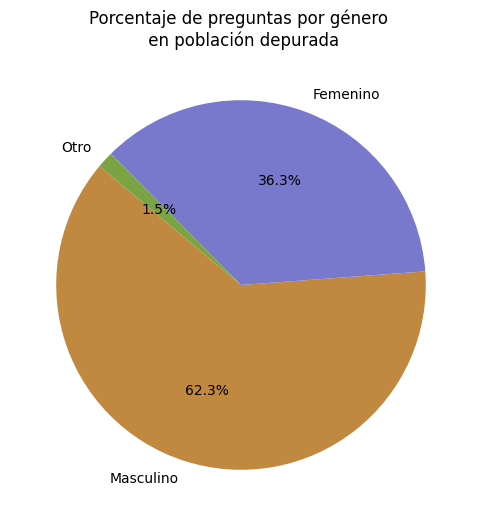

In [90]:
# Crear gráfica con porcentaje de preguntas por género en población depurada
column='genero'
figsize=(8,6)
plt.figure(figsize=(8, 6))
df_filtered[column].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title(f'Porcentaje de preguntas por género \n en población depurada')
plt.ylabel('')
plt.show()

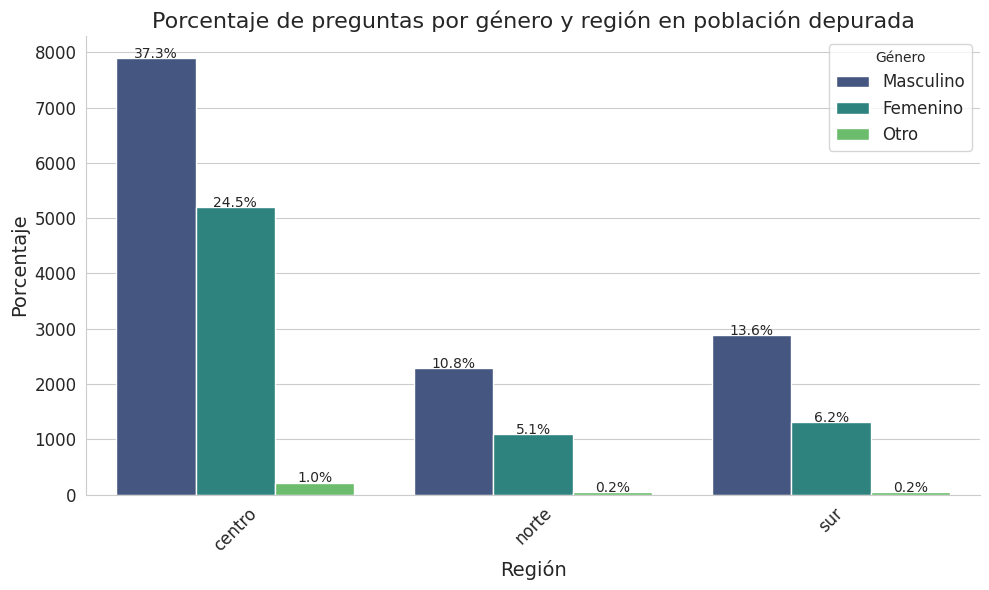

In [91]:
# Crear gráfica de barras comparativa de porcentaje de preguntas por género y por región en población depurada
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_filtered, x='region', hue=column, palette='viridis')

plt.title(f'Porcentaje de preguntas por género y región en población depurada', fontsize=16)
plt.xlabel('Región', fontsize=14)
plt.ylabel('Porcentaje', fontsize=14)

# Añadir etiquetas de porcentaje
total = len(df_filtered)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:.1f}%'.format((height / total) * 100),
                ha="center", fontsize=10)

# Eliminar las líneas de la parte superior y derecha del gráfico
sns.despine()

# Mostrar el gráfico
plt.legend(title='Género', fontsize=12)  # Ajustar leyenda
plt.xticks(rotation=45, fontsize=12)  # Ajustar el tamaño de las etiquetas del eje x
plt.yticks(fontsize=12)  # Ajustar el tamaño de las etiquetas del eje y
plt.tight_layout()  # Ajustar el espaciado
plt.show()


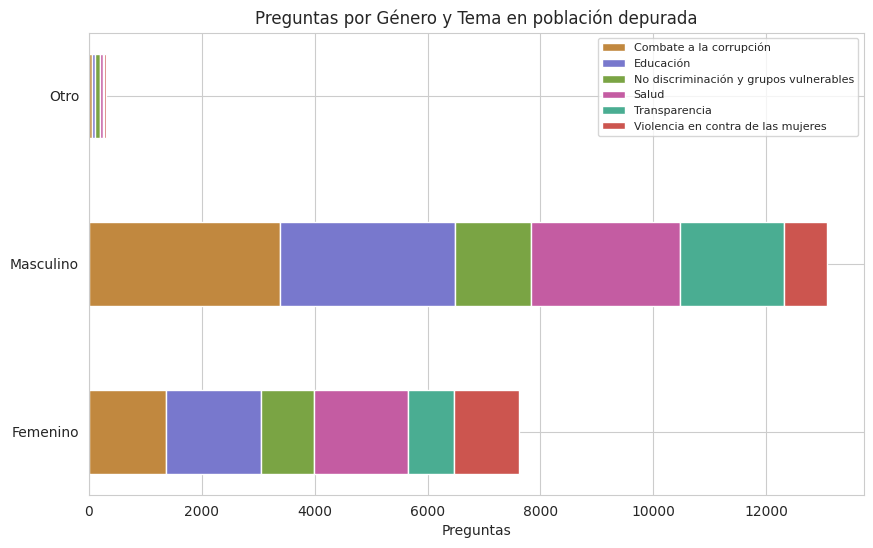

In [92]:
# Crear gráfica de barras apilada de preguntas por género y tema en población depurada
pivot_df_genero = df_filtered.pivot_table(index='genero', columns='tema', aggfunc='size', fill_value=0)

fig, ax = plt.subplots(figsize= (10,6))
barWidth = 0.5

for i, col in enumerate(pivot_df.columns):
    ax.barh(pivot_df_genero.index, pivot_df_genero[col], height=barWidth, left=np.sum(pivot_df_genero.iloc[:, :i], axis=1), label=col, color=topic_color_palette[i % len(topic_color_palette)])

plt.xlabel('Preguntas')
plt.title('Preguntas por Género y Tema en población depurada')
plt.yticks(rotation=0) 
plt.legend(fontsize='8', loc='upper right') 
plt.show()

### Preguntas por pertenencia a Grupos en Situación de Discriminación:


/tmp/ipykernel_32027/4123457498.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])


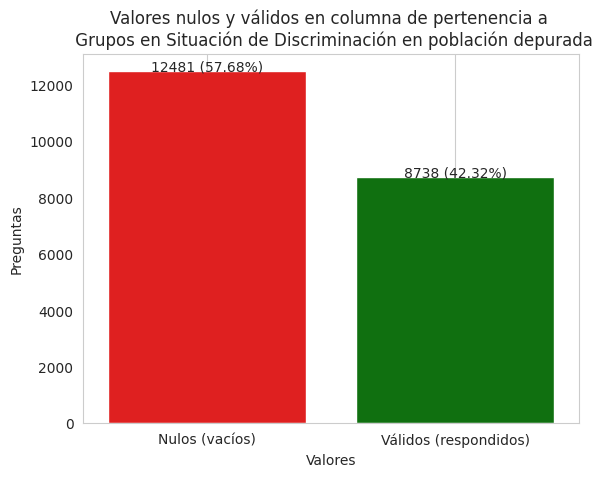

In [93]:
# Contar preguntas con valores nulos (vacías) y válidos (respondidas) en campo (opcional) para indicar Grupo en Situación de Discriminación
cantidad_nulos = df_filtered['grupos_discriminacion'].isnull().sum()
cantidad_no_nulos = df_filtered['grupos_discriminacion'].notnull().sum()

# Crear gráfica de barras con valores nulos y válidos
sns.barplot(x=['Nulos (vacíos)', 'Válidos (respondidos)'], y=[cantidad_nulos, cantidad_no_nulos], palette=['red', 'green'])
plt.xlabel('Valores')
plt.ylabel('Preguntas')
plt.title('Valores nulos y válidos en columna de pertenencia a \n Grupos en Situación de Discriminación en población depurada')

# Agregar los porcentajes a etiquetas
for i, valor in enumerate([cantidad_nulos, cantidad_no_nulos]):
    if i == 0:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_nulos:.2f}%)', ha='center')
    else:
        plt.text(i, valor + 0.5, f'{valor} ({pcntg_no_nulos:.2f}%)', ha='center')

plt.grid()
plt.show()

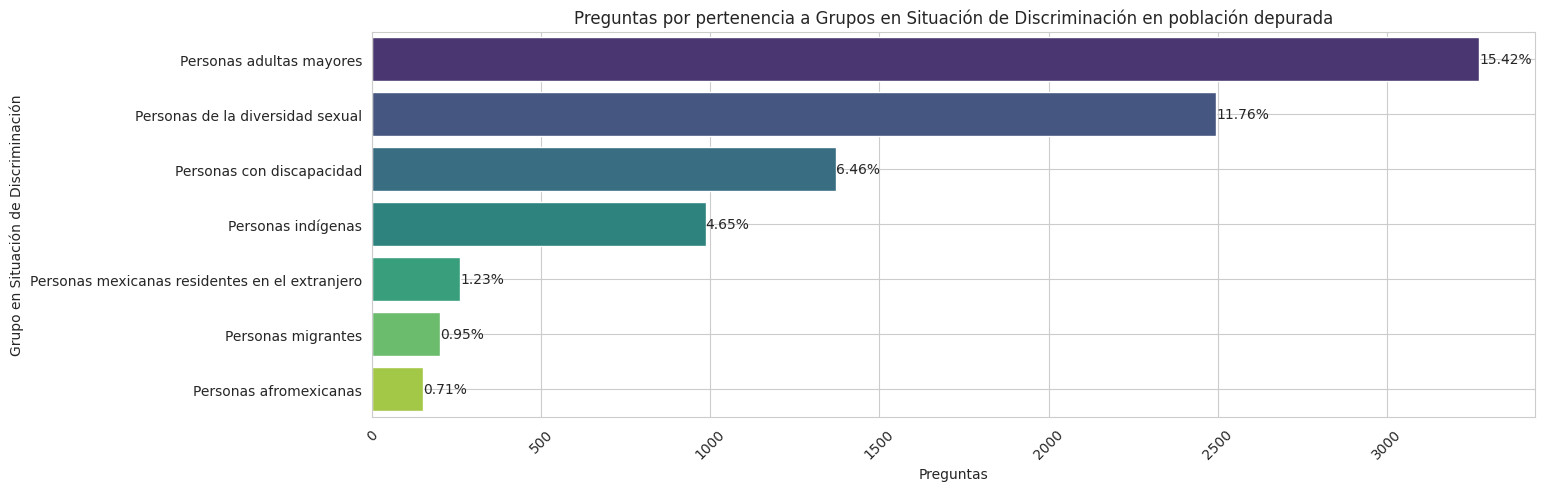

In [94]:
# Contar preguntas por grupo en situación de discriminación y calcular porcentajes
total_entries = len(df_filtered)
counts = df_filtered['grupos_discriminacion'].value_counts()
percentage = counts / total_entries * 100

# Crear gráfica de barras por grupos en situación de discriminación
column = 'Grupo Vulnerable'
figsize = (15, 5)
plt.figure(figsize=figsize)
sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis', dodge=False, hue=counts.index, legend=False)
plt.title(f'Preguntas por pertenencia a Grupos en Situación de Discriminación en población depurada')
plt.xlabel('Preguntas')
plt.ylabel('Grupo en Situación de Discriminación')
plt.xticks(rotation=45)
plt.grid(True)

# Añadir los valores de porcentaje en las barras
for i, val in enumerate(percentage):
    plt.text(counts.values[i], i, f'{val:.2f}%', fontsize=10, va='center')

plt.show()

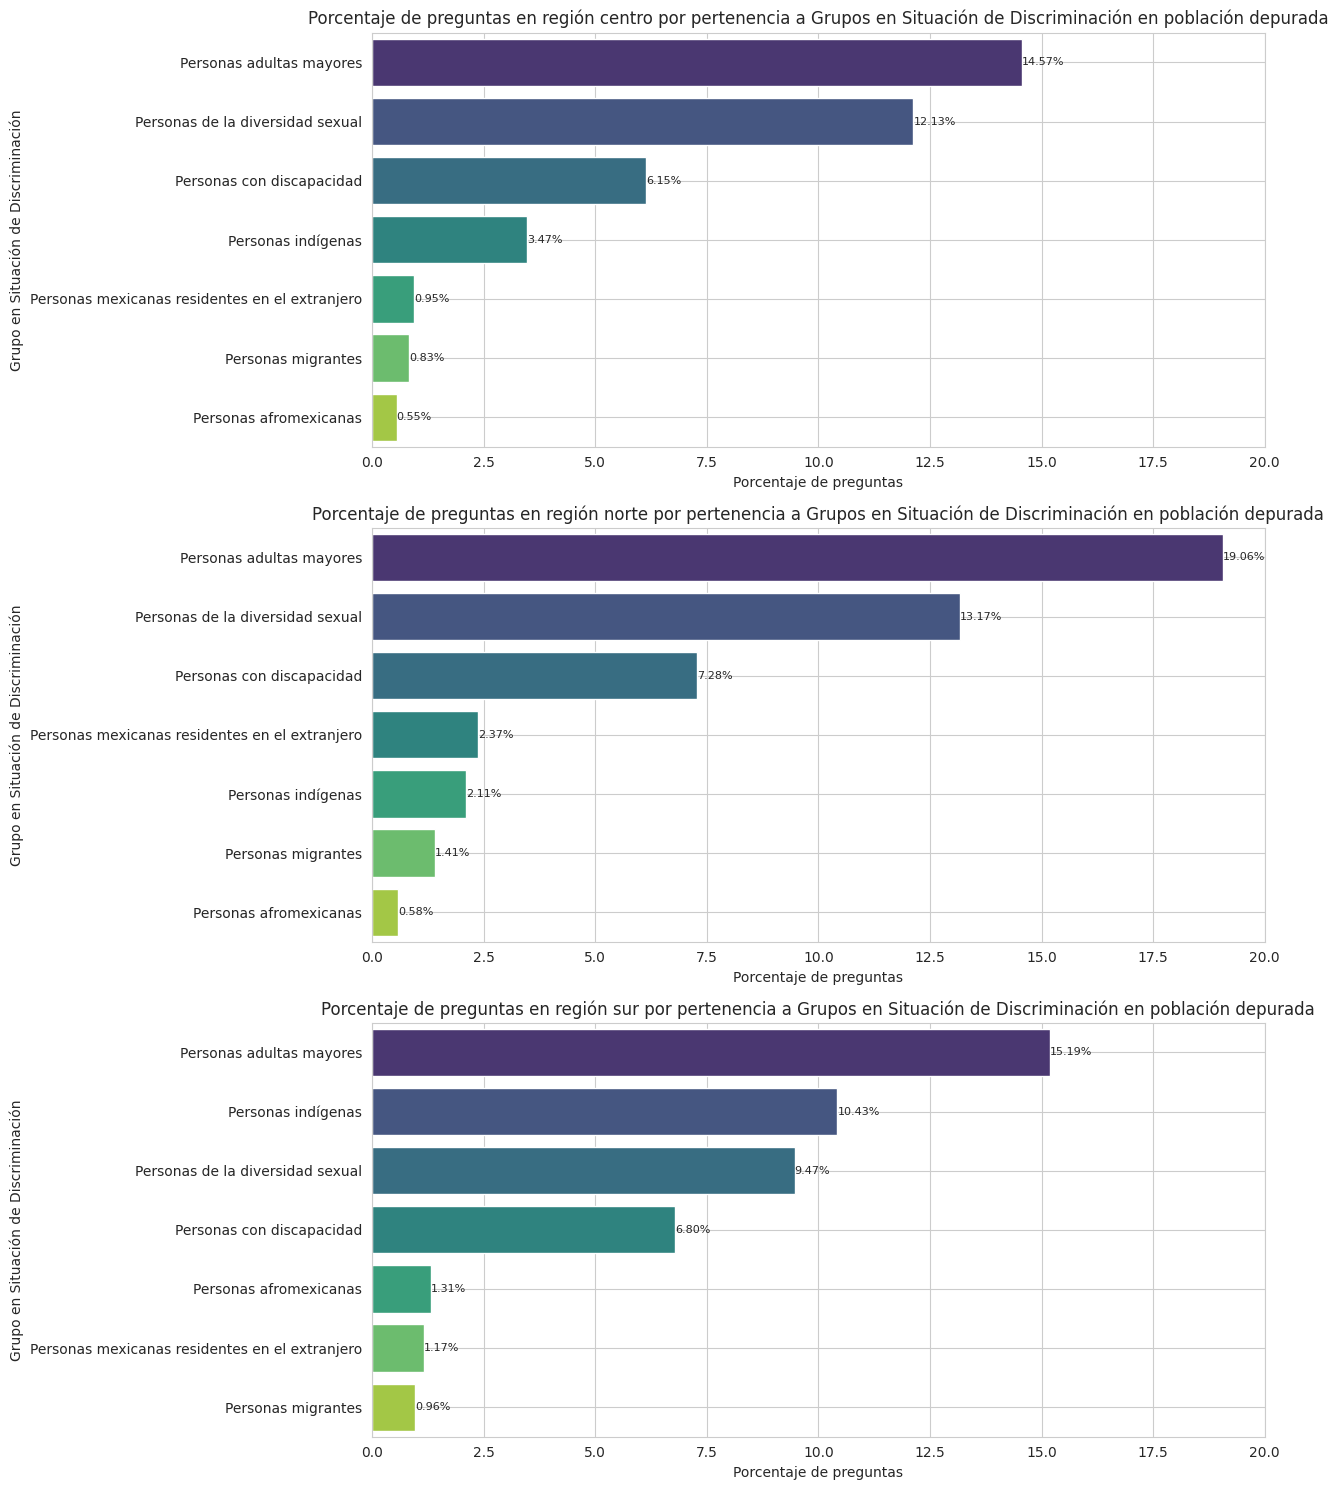

In [95]:
# Contar preguntas por grupo en situación de discriminación y región y calcular porcentajes
total_entries_region = df_filtered.groupby('region').size()
counts_region = df_filtered.groupby(['region', 'grupos_discriminacion']).size().unstack(fill_value=0)
percentage_region = counts_region.div(total_entries_region, axis=0) * 100

# Crear gráfica de barras por grupos en situación de discriminación por región
fig, axes = plt.subplots(nrows=len(percentage_region), figsize=(13, 5 * len(percentage_region)))
fig.subplots_adjust(hspace=0.5)

for i, (region, data) in enumerate(percentage_region.iterrows()):
    sorted_data = data.sort_values(ascending=False)
    ax = sns.barplot(x=sorted_data.values, y=sorted_data.index, hue=sorted_data.index, palette='viridis', ax=axes[i], legend=False)
    ax.set_title(f'Porcentaje de preguntas en región {region} por pertenencia a Grupos en Situación de Discriminación en población depurada')
    ax.set_xlabel('Porcentaje de preguntas')
    ax.set_ylabel('Grupo en Situación de Discriminación')
    ax.grid(True)

    # Añadir los valores de porcentaje en las barras
    for j, val in enumerate(sorted_data.values):
        ax.text(val, j, f'{val:.2f}%', fontsize=8, va='center')

    ax.set_xlim(0, 20)

plt.tight_layout()
plt.show()

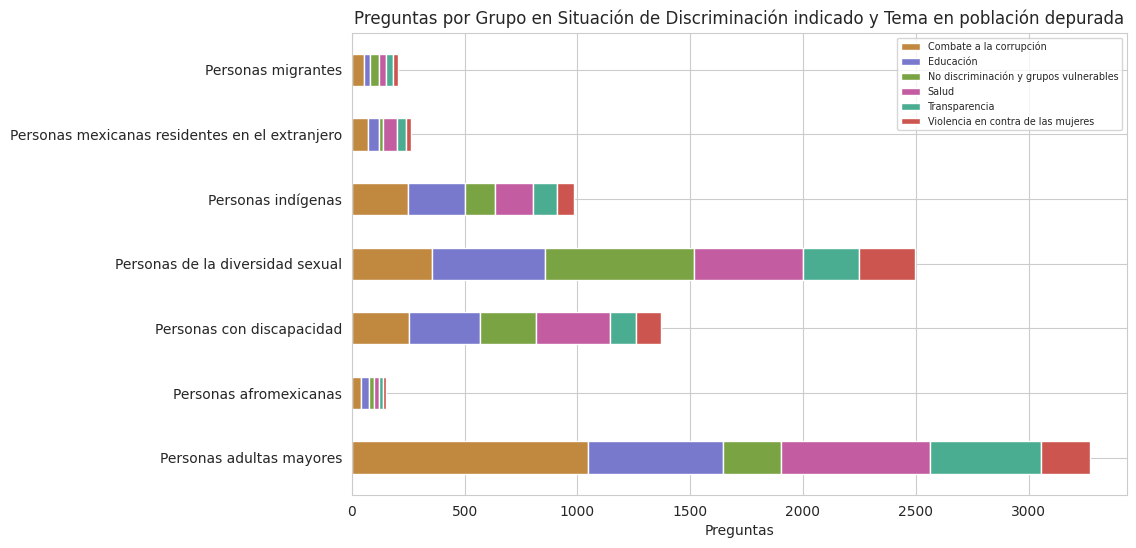

In [96]:
# Crear gráfica de barras apilada de preguntas por tema y grupo en situación de discriminación en población depurada
pivot_df = df_filtered.pivot_table(index='grupos_discriminacion', columns='tema', aggfunc='size', fill_value=0)

fig, ax = plt.subplots(figsize= (10,6))
barWidth = 0.5

for i, col in enumerate(pivot_df.columns):
    ax.barh(pivot_df.index, pivot_df[col], height=barWidth, left=np.sum(pivot_df.iloc[:, :i], axis=1), label=col, color=topic_color_palette[i % len(topic_color_palette)])

plt.xlabel('Preguntas')
plt.title('Preguntas por Grupo en Situación de Discriminación indicado y Tema en población depurada')
plt.yticks(rotation=0) 
plt.legend(fontsize='x-small', loc='upper right') 
plt.show()

## 7. Cálculo y elaboración de muestra estratificada



Definir parámetros y función para **calcular tamaño de muestra:**

In [97]:
# Definir parámetros y función para cálculo de tamaño de muestra
Z=2.58 # Nivel de confianza: 99%
p=0.5 # Proporción que presenta el atributo
q=1-p # Complemento de "p"
N=len(df_filtered) # Población. Se debe ajustar según el total de la base depurada
e=0.03 # Error de estimación: 3%

# Fórmula para calcular tamaño de muestra
tam=math.ceil((Z**2*N*p*q)/(e**2*(N-1)+Z**2*p*q))

# Definir fución para realizar cálculo de muestra con doble estratificación (región y tema)
def calculateSampleSizes(n):
    resultados = []

      # Iterar sobre las regiones y temas para calcular los tamaños de muestra
    for region in ["norte", "centro", "sur"]:
        pobReg = len(df_filtered[df_filtered["region"] == region])
        muestraRegCrudo = round(pobReg/len(df_filtered)*n)
        #muestraRegion = muestraRegCrudo+1 if muestraRegCrudo % 2 == 0 else (muestraRegCrudo)
        muestraRegion = muestraRegCrudo
        for tema in ["Salud", "Educación", "Combate a la corrupción", "Transparencia", "No discriminación y grupos vulnerables", "Violencia en contra de las mujeres"]:
            pobRegTema = len(df_filtered[(df_filtered["region"] == region) & (df_filtered["tema"] == tema)])
        
            propMuestraRegTema = pobRegTema/pobReg
            tamMuestraRegTema =  round(propMuestraRegTema*muestraRegion)

            #Agregar el resultado al DataFrame de resultados
            resultados.append({"region": region, "tema": tema, "tamMuestra": tamMuestraRegTema})
            #Agregar resultados proporcion
           #resultados_proporcion.append({"region": region, "tema": tema, "Proporcion_Muestra": math.ceil(propMuestraRegTema,3)})
    resultados = pd.DataFrame(resultados)
    # Pivotar los datos para crear una tabla con regiones como filas y temas como columnas
    tabla_tamMuestra = resultados.pivot_table(index='region', columns='tema', values='tamMuestra', aggfunc='sum', fill_value=0)
    # Calcular el total por región
    tabla_tamMuestra['Total por Región'] = tabla_tamMuestra.sum(axis=1)

    # Calcular el total por tema
    tabla_tamMuestra.loc['Total por Tema'] = tabla_tamMuestra.sum(axis=0)


    
    
    return tabla_tamMuestra, resultados

In [98]:
# Ejecutar función para calcular tamaño de muestra
tabla_tamMuestraTamanoFormula, resultados = calculateSampleSizes(tam)

In [99]:
# Imprimir tamaño de muestra calculado
tam

1701

In [100]:
# Ejecutar cálculo de muestra con doble estratificación (tema y región)
counts_region = df_filtered.groupby(['region', 'tema']).size().unstack(fill_value=0)
counts_region['Total por región'] = counts_region.sum(axis=1)
counts_region.loc['Total por tema'] = counts_region.sum(axis=0)

# Visualizar tabla con conteo de preguntas por región y tema de población depurada de preguntas
counts_region

tema,Combate a la corrupción,Educación,No discriminación y grupos vulnerables,Salud,Transparencia,Violencia en contra de las mujeres,Total por región
region,,,,,,,
centro,2939,3030,1574,2811,1789,1346,13489
norte,861,831,380,724,418,249,3463
sur,1052,1011,450,872,529,353,4267
Total por tema,4852,4872,2404,4407,2736,1948,21219


In [101]:
# Visualizar tabla con estratos calculados por región y tema para la muestra
tabla_tamMuestraTamanoFormula

tema,Combate a la corrupción,Educación,No discriminación y grupos vulnerables,Salud,Transparencia,Violencia en contra de las mujeres,Total por Región
region,,,,,,,
centro,236,243,126,225,143,108,1081
norte,69,67,31,58,34,20,279
sur,84,81,36,70,42,28,341
Total por Tema,389,391,193,353,219,156,1701


In [102]:
# Enlistar estratos calculados por región y tema
resultados

,region,tema,tamMuestra
0,norte,Salud,58
1,norte,Educación,67
2,norte,Combate a la corrupción,69
3,norte,Transparencia,34
4,norte,No discriminación y grupos vulnerables,31
5,norte,Violencia en contra de las mujeres,20
6,centro,Salud,225
7,centro,Educación,243
8,centro,Combate a la corrupción,236
9,centro,Transparencia,143


In [103]:
# Exportar tabla con distribución de preguntas por tema y región en muestra
tabla_tamMuestraTamanoFormula.to_csv('tabla_tamMuestraTamanoFormula.csv', index=False)

Definir función para **generar muestra estratificada:**

In [105]:
def generateSample(df, tam, tema, region, seed):
  # Filtrar por región y tema si es necesario
  dfw = df[(df["region"] == region) & (df["tema"] == tema)]
  
  # Tomar una muestra aleatoria del tamaño especificado
  sampled_questions = dfw.sample(n=tam, replace=False, random_state=seed)
  words = tema.split(" ")  # Dividir el tema en palabras
  tema_lower = "-".join([word.lower() for word in words])  # Convertir a minúsculas y unir con guiones
  sampled_questions["muestra"] = f"{region}-{tema_lower}"

  return sampled_questions

Ejecutar función para **generar muestra estratificada** de preguntas:

In [106]:
# Añadir semilla (seed number) para fijar generación aleatoria y ejecutar función para extraer muestra estratificada
seed = 20240407
datasetMuestra = pd.DataFrame()
datasetM = generateSample(df_filtered, 225, "Salud", "centro", seed)
datasetMuestra = pd.concat([generateSample(df_filtered, row["tamMuestra"], row["tema"], row["region"], seed) for i, row in resultados.iterrows()])

In [107]:
datasetMuestra.shape

(1701, 13)

In [108]:
print(f"Población total: {N}")
print(f"Tamaño muestra: {tam}")

Población total: 21219
Tamaño muestra: 1701


Mostrar tabla con **distribución de estratos en muestra:**

In [109]:
resultadosMuestreo = []

# Iterar sobre las regiones y temas para calcular los tamaños de muestra
for region in ["norte", "centro", "sur"]:
    for tema in ["Salud", "Educación", "Combate a la corrupción", "Transparencia", "No discriminación y grupos vulnerables", "Violencia en contra de las mujeres"]:
        pobRegTema = len(datasetMuestra[(datasetMuestra["region"] == region) & (datasetMuestra["tema"] == tema)])
        resultadosMuestreo.append({"region": region, "tema": tema, "tamMuestra": pobRegTema})

# Convertir la lista de resultados en un DataFrame
resultadosMuestreo = pd.DataFrame(resultadosMuestreo)

# Crear una tabla pivotante para mostrar los tamaños de muestra reales por región y tema
tabla_tamMuestraReal = resultadosMuestreo.pivot_table(index='region', columns='tema', values='tamMuestra', aggfunc='sum', fill_value=0)

# Calcular el total por región y el total por tema
tabla_tamMuestraReal['Total por Region'] = tabla_tamMuestraReal.sum(axis=1)
tabla_tamMuestraReal.loc['Total por Tema'] = tabla_tamMuestraReal.sum(axis=0)

# Mostrar la tabla de tamaños de muestra reales
tabla_tamMuestraReal

tema,Combate a la corrupción,Educación,No discriminación y grupos vulnerables,Salud,Transparencia,Violencia en contra de las mujeres,Total por Region
region,,,,,,,
centro,236,243,126,225,143,108,1081
norte,69,67,31,58,34,20,279
sur,84,81,36,70,42,28,341
Total por Tema,389,391,193,353,219,156,1701


In [110]:
# Exportar archivo de datos en formato CSV con muestra estratificada de 1,701 preguntas
datasetMuestra.to_csv(f'{nombreArchivo}_MuestraEstratificada.csv')

## 8. Referencias

*   Bird, Steven, Edward Loper & Ewan Klein (2009).
Natural Language Processing with Python.  O'Reilly Media Inc.
*   Guzmán Falcón, E. (2018). Detección de lenguaje ofensivo en Twitter basada en expansión automática de lexicones (Tesis de Maestría). Instituto Nacional de Astrofísica, Óptica y Electrónica. Recuperado de https://inaoe.repositorioinstitucional.mx/jspui/bitstream/1009/1722/1/GuzmanFE.pdf
*   Instituto Nacional Electoral. (2024). Acuerdo INE/CG95/2024. Acuerdo del Consejo General del Instituto Nacional Electoral por el que se define la metodología, así como la instancia que seleccionará las preguntas provenientes de redes sociales relativas al Formato Tipo A que se utilizará en el Primer Debate Presidencial en el Proceso Electoral Federal 2023-2024. Repositorio Documental INE. https://repositoriodocumental.ine.mx/xmlui/bitstream/handle/123456789/164296/CGex202402-08-ap-3.pdf
* Instituto Nacional Electoral. (2024). Anexo I. Metodología Selección de Preguntas para Debate Formato A. Recuperado de: https://repositoriodocumental.ine.mx/xmlui/bitstream/handle/123456789/164296/CGex202402-08-ap-3-a1.pdf
* Kiss, T., & Strunk, J. (2006). Unsupervised Multilingual Sentence Boundary Detection. Computational Linguistics, 32(4), 485-525. https://doi.org/10.1162/coli.2006.32.4.485
*   Signa_Lab ITESO. (2022). Lexicon para identificar violencia con razón de género. Signa_Lab ITESO.

---